## Занятие 07. "Метод ближайших соседей и деревья решений"
Домашнее задание выполнено **Мельниковой Маргаритой**

---
### Задача
- Снова домашка с предсказанием цены на недвижимость.
- Всё, что изучали ранее примените для этого датасета. В вашем арсенале не только модель линейной регрессии, но и метод ближайших соседей. Посмотрите, что лучше предсказывает median_house_value. Кроме того, вы можете посмотреть, какие результаты будут с применением PCA.

### Описание датасета:

|Feature|Description
|---|---|
|longitude|A measure of how far west a house is; </br> a higher value is farther west
|latitude|A measure of how far north a house is; </br> a higher value is farther north
|housingMedianAge|Median age of a house within a block; </br> a lower number is a newer building
|totalRooms|Total number of rooms within a block
|totalBedrooms|Total number of bedrooms within a block
|population|Total number of people residing within a block
|households|Total number of households, a group of people residing within a home unit, for a block
|medianIncome|Median income for households within a block of houses </br> (measured in tens of thousands of US Dollars)
|medianHouseValue|Median house value for households within a block </br> (measured in US Dollars)
|oceanProximity|Location of the house w.r.t ocean/sea

---
### Решение

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# importing dataset
url = 'https://drive.google.com/file/d/1bcTxmoe6E9tUkze-gO9rZuoKsHJL6ZH4/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]

data = pd.read_csv(path)

In [3]:
data.shape

(20640, 10)

In [4]:
data = data.drop_duplicates()
data.shape

(20640, 10)

In [5]:
rows_initial = data.shape[0]

Дубликатов нет

#### Мои функции для дальнейшей работы

In [6]:
def iqr(df, column):
    '''
    Находим границы для аутлаеров
    https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097
    
    '''
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    quartile_lower = Q1 - 1.5 * IQR
    quartile_higher = Q1 + 1.5 * IQR
    return quartile_lower, quartile_higher

def cat_feat_plot(df, x_list, y_name):
    '''
    Графики для категориальных переменных
    '''
    for el in x_list:
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,1)
        plt.title(el + ' histogram')
        sns.countplot(data=df, x=el)

        plt.subplot(1,2,2)
        plt.title(el + ' pointplot')
        sns.pointplot(data=df, x=el, y=y_name)

        plt.show()
        
def num_feat_plot(df, x_list, y_name):
    '''
    Графики для числовых переменных
    '''
    for el in x_list:
        plt.figure(figsize=(10, 5))
        plt.subplot(1,2,1)
        plt.title(el + ' histogram')
        sns.histplot(data=df, x=el) # hue=y_name убрала

        plt.subplot(1,2,2)
        plt.title(el + ' boxplot')
        sns.boxplot(data=df, x=el)

        plt.show()

In [7]:
def magic_scatterplot(df, hue_list, x_name, y_name):
    '''
    Scatterplot with continuous hues
    '''
    for el in hue_list:
        plt.figure(figsize=(15, 10))
#         plt.title(el + ' scatterplot')
        sns.relplot(
            data=df,
            x=x_name, y=y_name,
            hue=el)

        plt.show()

In [8]:
# https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

#### Знакомство с данными

In [9]:
data.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [11]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

> Пропуски в %

In [12]:
data.isna().mean()

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64

> Пропуски есть только в total_bedrooms. </br>

> Почему-то количество комнат - float. Нужно посмотреть. Заодно и посмотрим спальни.

In [13]:
temp = data.copy()
temp['total_rooms_int'] = temp['total_rooms'].astype('int64')
print(sum(temp['total_rooms_int'] - temp['total_rooms']))

temp['total_bedrooms'] = temp['total_bedrooms'].fillna(0)
temp['total_bedrooms_int'] = temp['total_bedrooms'].astype('int64')
print(sum(temp['total_bedrooms_int'] - temp['total_bedrooms']))

0.0
0.0


> Почему-то количество комнат - float. Нужно посмотреть. Заодно и посмотрим спальни.

In [14]:
temp = data['total_rooms'] - data['total_bedrooms']
len(temp[temp < 0])

0

> Отлично, логический контроль на комнаты пройден

#### Доработаем датасет

> Переведем median_house_value в тысячи долларов

In [15]:
data['median_house_value'] = data['median_house_value'] / 1000

> Рассчитаем показатели 
> - средний размер домохозяйства
> - среднее число комнат на домохозяйство
> - среднее число спален на домохозяйство
> - средний доход на человека в домохозяйстве

In [16]:
data['avg_household_size'] = data['population'] / data['households']
data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_household'] = data['total_bedrooms'] / data['households']
data['median_income_per_person'] = data['median_income'] * data['households'] / data['population']

> Распишем переменные по типам согласно их типам в датафрейме и по значениям.

In [17]:
list(data.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'avg_household_size',
 'rooms_per_household',
 'bedrooms_per_household',
 'median_income_per_person']

In [18]:
num = [
     'longitude',
     'latitude',
     'housing_median_age',
     'total_rooms',
     'total_bedrooms',
     'population',
     'households',
     'median_income',
     'avg_household_size',
     'rooms_per_household',
     'bedrooms_per_household',
     'median_income_per_person'
] # числовые переменные

cat = [
    'ocean_proximity'
] # категориальные

target = [
     'median_house_value'] # целевое значение

In [19]:
assert len(num) + len(cat) + len(target)  == data.shape[1], 'Check split'

#### Посмотрим, что получается по данным

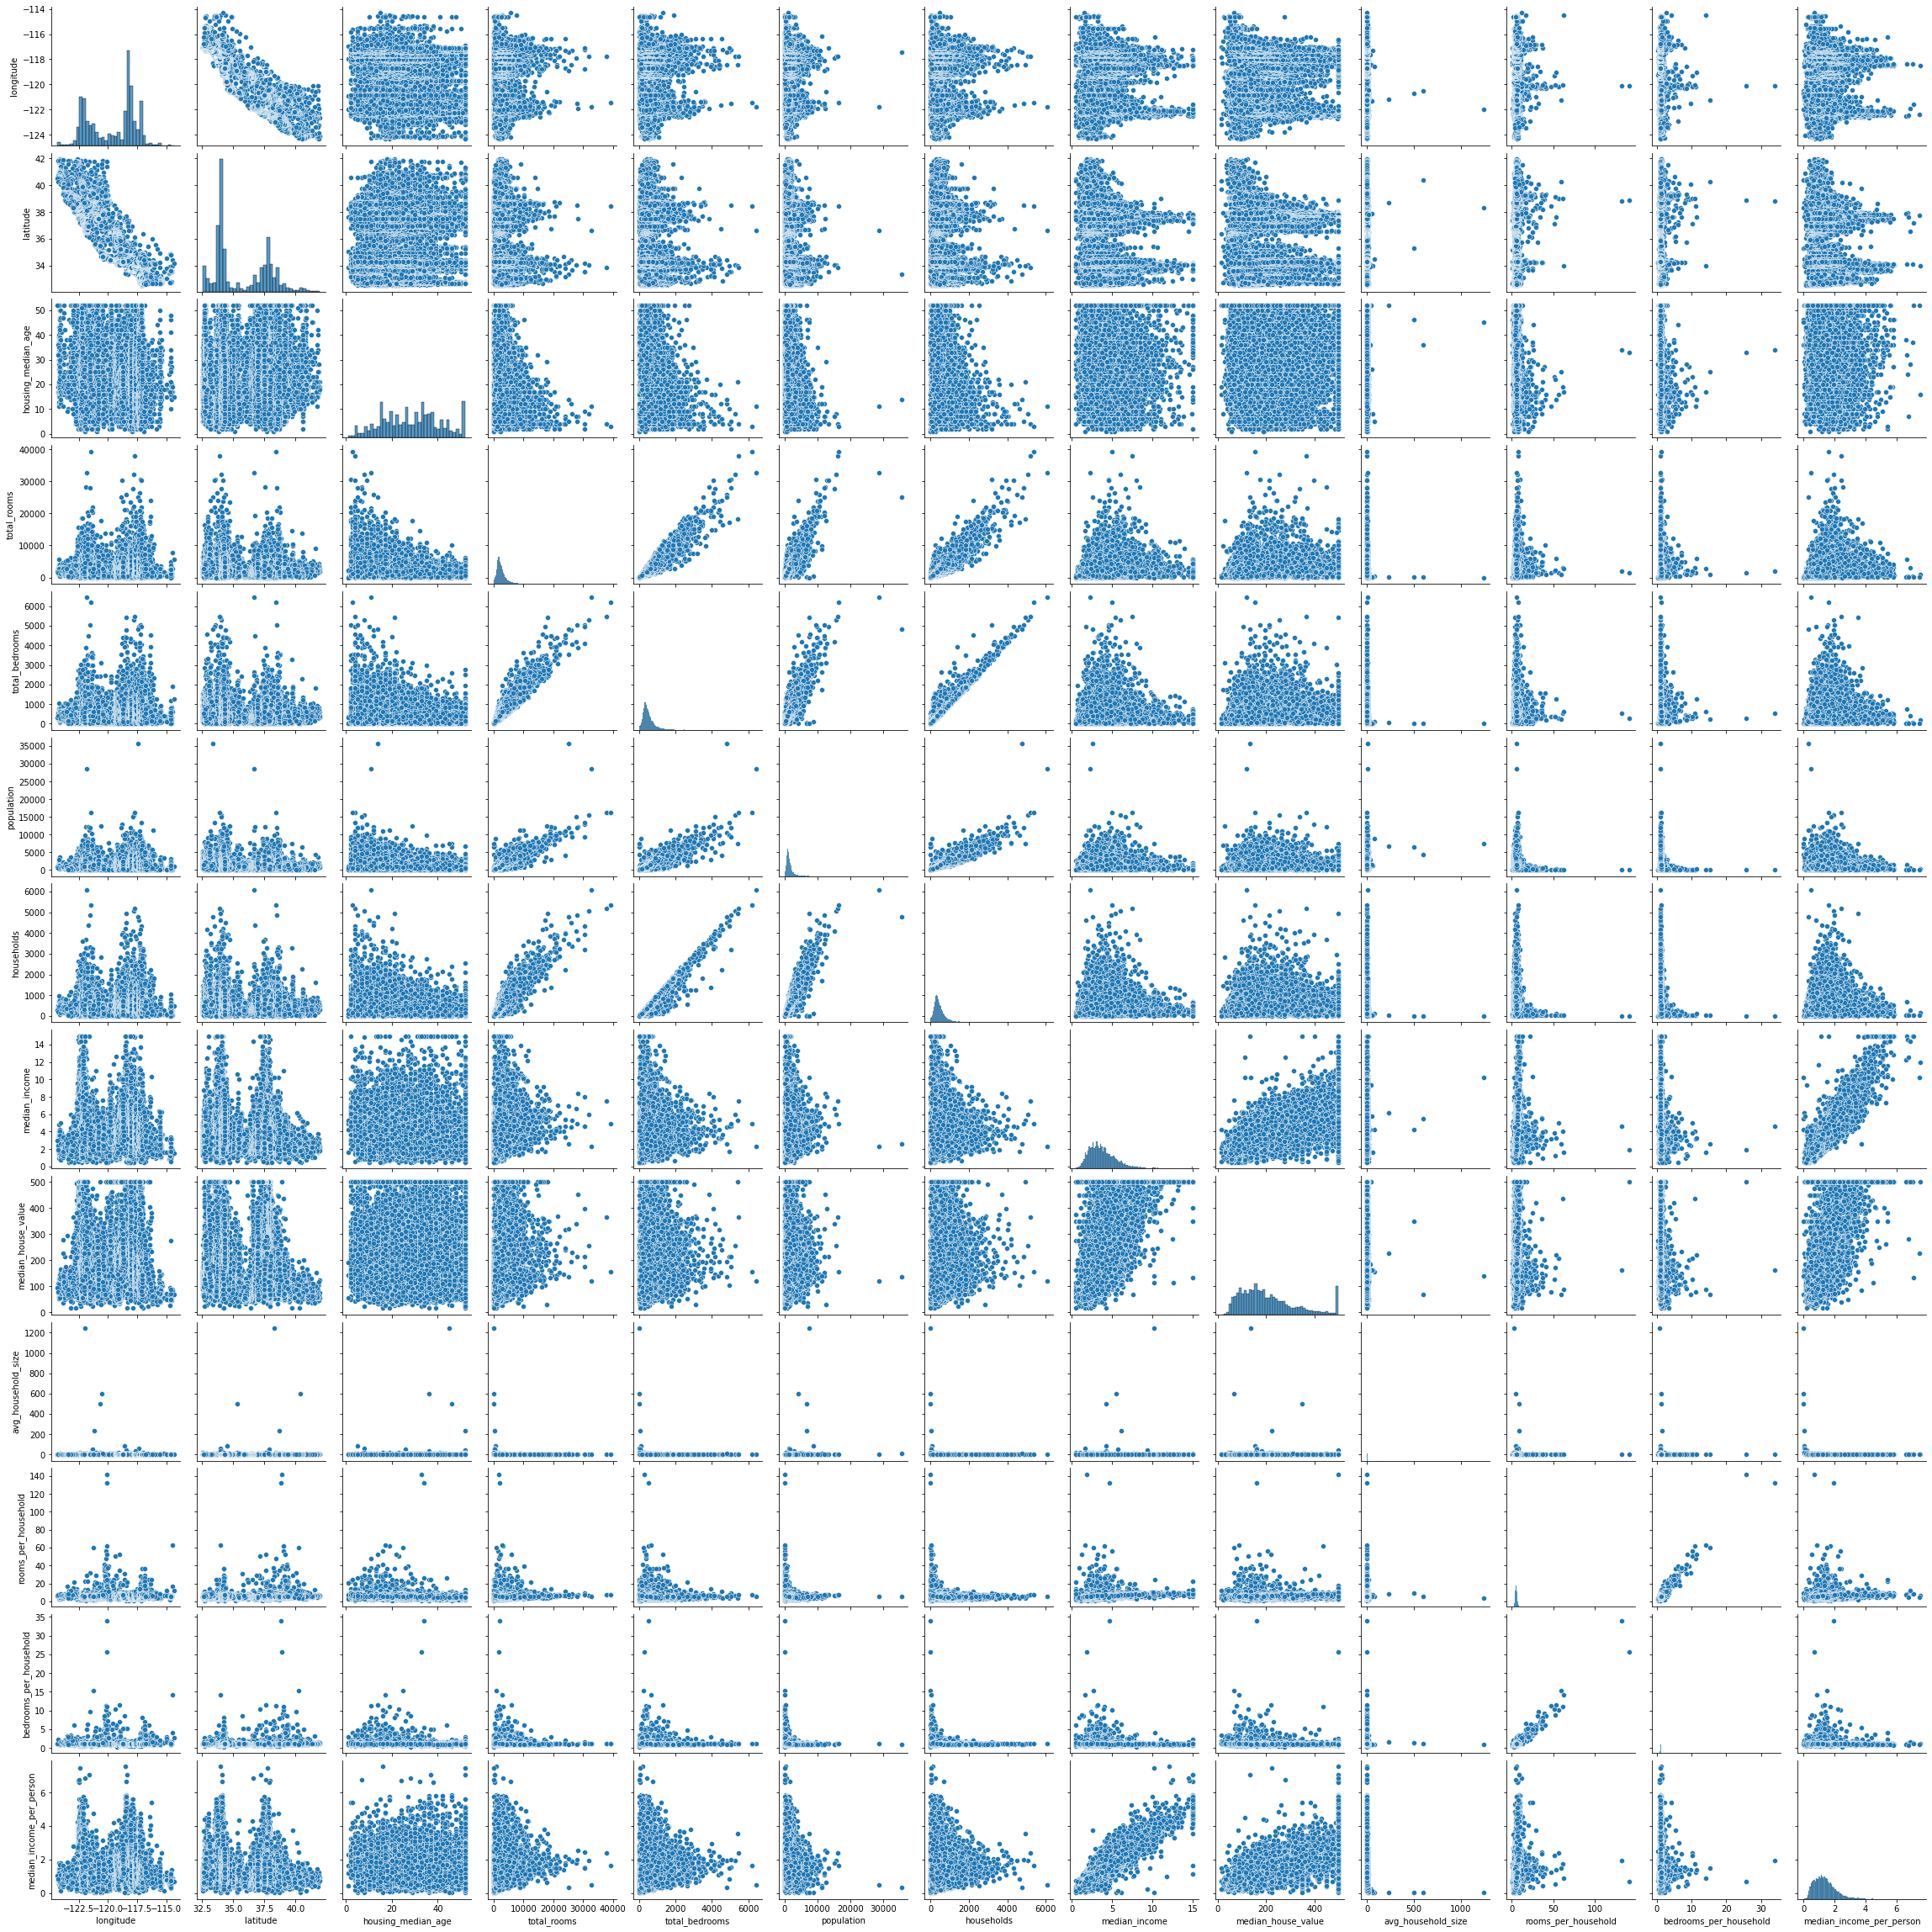

In [20]:
sns.pairplot(data)

In [21]:
data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  avg_household_size  rooms_per_household  \
count        20640.000000        20640.000000         20640.000000   
mean           206.855817            3.070655             5.429000   
std            115.395616           10.386050             2.474173   
min             14.999000            0.692308             0.846154   
25%            119.600000            2.429741             4.440716   
50%            179.700000            2.818116             5.229129   
75%            264.725000            3.282261             6.052381   
max            500.001000         1243.333333           141.909091   

       bedrooms_per_household  median_income_per_person  
count            20433.000000              20640.000000  
mean                 1.097062                  1.408324  
std                  0.476104                  0.755017  
min                  0.333333                  0.008225  
25%                  1.006029                  0.869633  
50%                  1.048889                  1.295461  
75%                  1.099631                  1.775809  
max                 34.066667                  7.549836

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

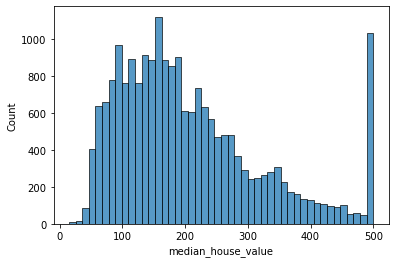

In [22]:
sns.histplot(data=data, x='median_house_value')

In [23]:
data[data['median_house_value'] > 500].head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
89     -122.27     37.80                52.0        249.0            78.0   
459    -122.25     37.87                52.0        609.0           236.0   
493    -122.24     37.86                52.0       1668.0           225.0   
494    -122.24     37.85                52.0       3726.0           474.0   
509    -122.23     37.83                52.0       2990.0           379.0   

     population  households  median_income  median_house_value  \
89        396.0        85.0         1.2434             500.001   
459      1349.0       250.0         1.1696             500.001   
493       517.0       214.0         7.8521             500.001   
494      1366.0       496.0         9.3959             500.001   
509       947.0       361.0         7.8772             500.001   

    ocean_proximity  avg_household_size  rooms_per_household  \
89         NEAR BAY            4.658824             2.929412   
459        NEAR BAY            5.396000             2.436000   
493        NEAR BAY            2.415888             7.794393   
494        NEAR BAY            2.754032             7.512097   
509        NEAR BAY            2.623269             8.282548   

     bedrooms_per_household  median_income_per_person  
89                 0.917647                  0.266891  
459                0.944000                  0.216753  
493                1.051402                  3.250192  
494                0.955645                  3.411688  
509                1.049861                  3.002819

In [24]:
len(data[data['median_house_value'] > 500]['median_house_value'].unique())

1

In [25]:
len(data[data['median_house_value'] > 500])

965

> Хм... 965 уникальных строк (на дубликаты уже проверила) имеют одинаковую стоимость? Явно, что-то не то. Уберем эти строки.

> Сделаю копию датафрейма, где уже уберу аномалии. 

In [26]:
df = data.copy()
df = df[df['median_house_value'] != 500.001]

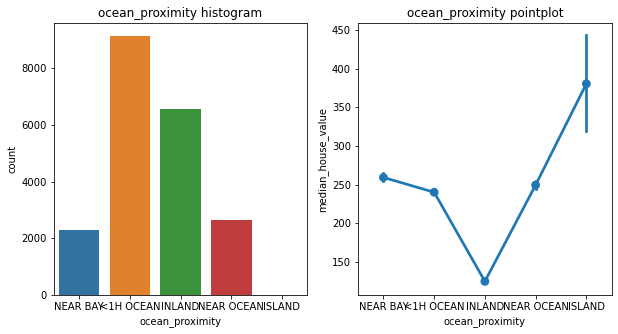

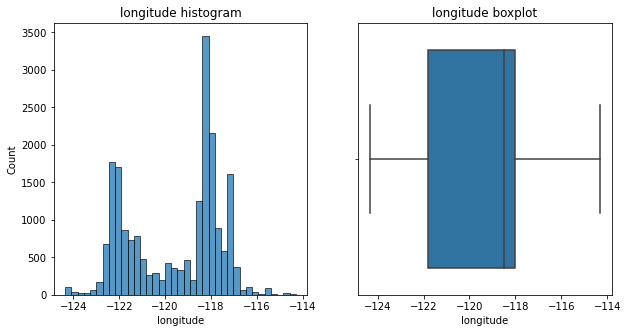

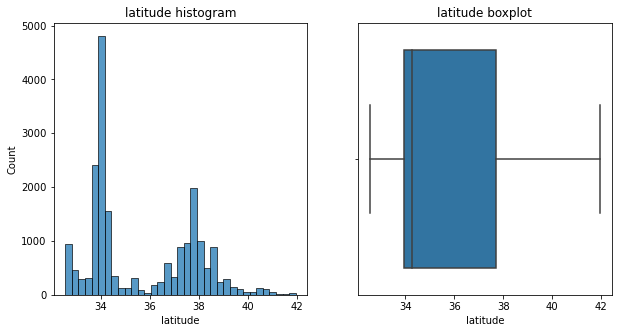

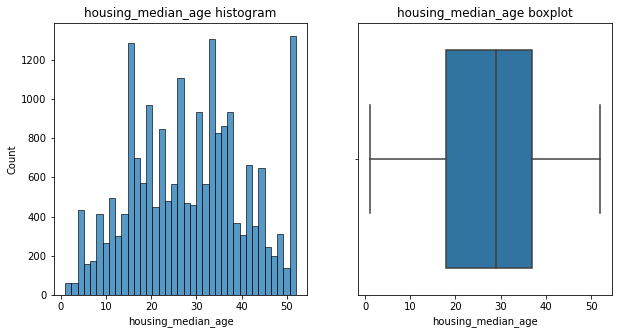

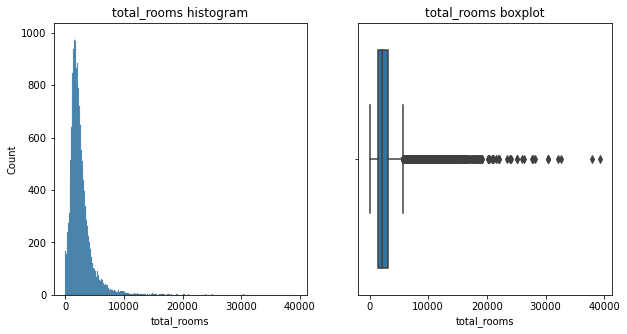

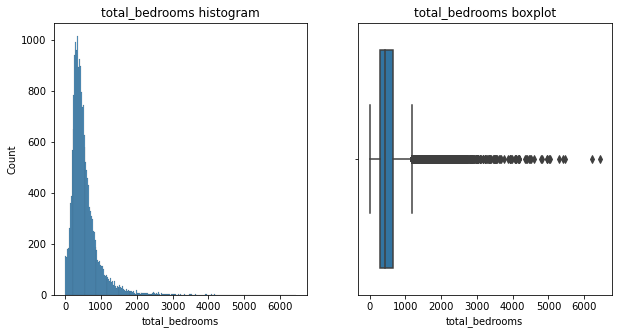

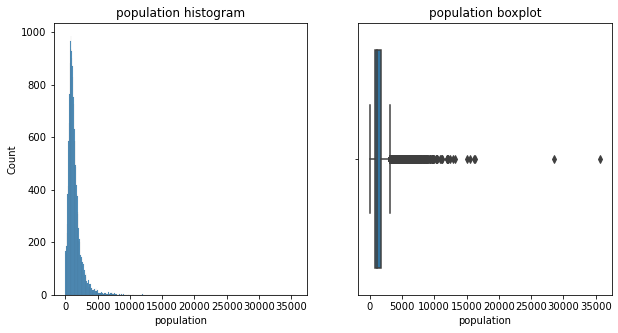

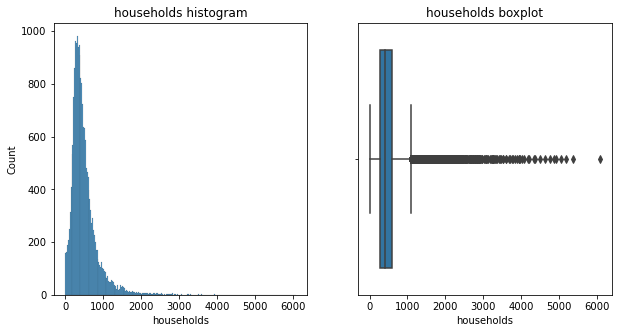

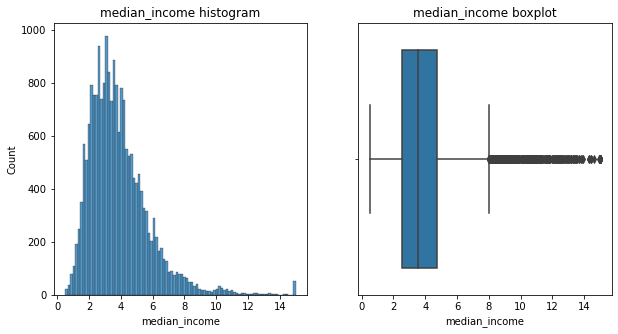

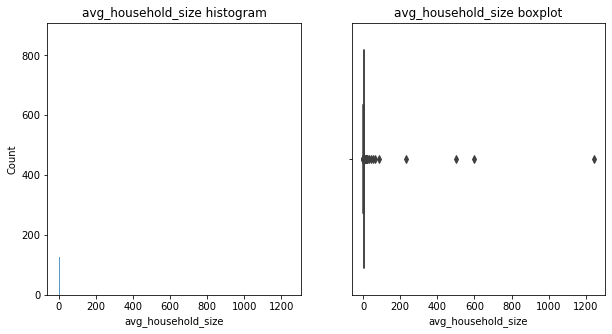

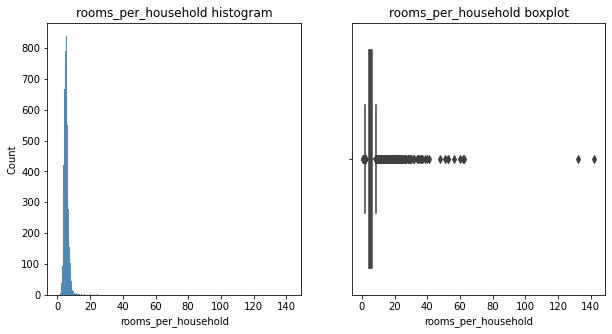

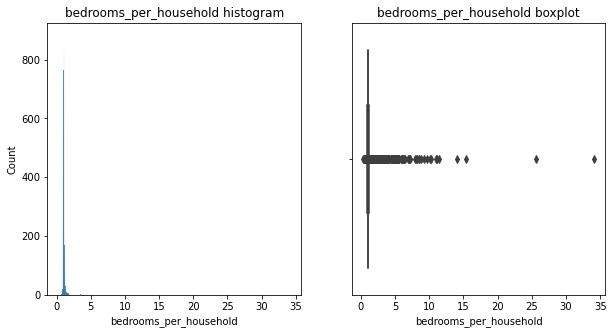

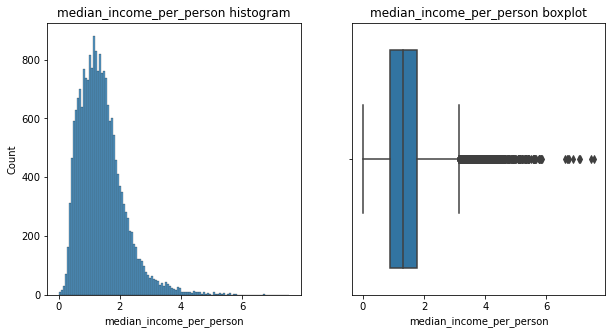

In [27]:
cat_feat_plot(data, cat, 'median_house_value')   
num_feat_plot(data, num, 'median_house_value')

> Есть еще выбросы, нужно разбираться. Легче всего с относительных показателей начать. </br>

In [28]:
df[['avg_household_size',
     'rooms_per_household',
     'bedrooms_per_household',
     'median_income_per_person']].describe()

avg_household_size  rooms_per_household  bedrooms_per_household  \
count        19675.000000         19675.000000            19475.000000   
mean             3.095189             5.360901                1.097017   
std             10.631977             2.292538                0.453933   
min              0.692308             0.846154                0.333333   
25%              2.445486             4.414568                1.005888   
50%              2.837134             5.184322                1.048780   
75%              3.304894             5.970677                1.099462   
max           1243.333333           132.533333               34.066667   

       median_income_per_person  
count              19675.000000  
mean                   1.325173  
std                    0.628748  
min                    0.008225  
25%                    0.848944  
50%                    1.257601  
75%                    1.705277  
max                    7.462508

In [29]:
q_l, q_h = iqr(df=df, column='avg_household_size')
print('Нижняя граница {} и верхняя граница {}'.format(q_l, q_h))

Нижняя граница 1.1563743977030723 и верхняя граница 3.734597389130783


In [30]:
df[df['avg_household_size'] < 1]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5342     -118.44     34.04                16.0         18.0             6.0   
11849    -121.00     39.75                 8.0       1116.0           214.0   
19522    -121.00     37.65                17.0        484.0           202.0   

       population  households  median_income  median_house_value  \
5342          3.0         4.0         0.5360               350.0   
11849        27.0        39.0         2.5893                83.0   
19522       198.0       204.0         0.6825               187.5   

      ocean_proximity  avg_household_size  rooms_per_household  \
5342        <1H OCEAN            0.750000             4.500000   
11849          INLAND            0.692308            28.615385   
19522          INLAND            0.970588             2.372549   

       bedrooms_per_household  median_income_per_person  
5342                 1.500000                  0.714667  
11849                5.487179                  3.740100  
19522                0.990196                  0.703182

In [31]:
df = df.drop(df[df['avg_household_size'] < 1].index)
df.shape[0] - rows_initial == -3 - 965

True

In [32]:
df[df['avg_household_size'] > 20]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
3364     -120.51     40.41                36.0         36.0             8.0   
5986     -117.71     34.10                52.0        567.0           152.0   
9172     -118.59     34.47                 5.0        538.0            98.0   
12104    -117.33     33.97                 8.0        152.0            19.0   
13034    -121.15     38.69                52.0        240.0            44.0   
13366    -117.63     33.94                36.0        447.0            95.0   
16420    -121.29     37.89                26.0        161.0            27.0   
16669    -120.70     35.32                46.0        118.0            17.0   
19006    -121.98     38.32                45.0         19.0             5.0   

       population  households  median_income  median_house_value  \
3364       4198.0         7.0         5.5179                67.5   
5986       2688.0       126.0         1.8750               212.5   
9172       8733.0       105.0         4.2391               154.6   
12104      1275.0        20.0         1.6250               162.5   
13034      6675.0        29.0         6.1359               225.0   
13366      2886.0        85.0         4.2578               183.3   
16420      1542.0        30.0         5.7485               162.5   
16669      6532.0        13.0         4.2639               350.0   
19006      7460.0         6.0        10.2264               137.5   

      ocean_proximity  avg_household_size  rooms_per_household  \
3364           INLAND          599.714286             5.142857   
5986           INLAND           21.333333             4.500000   
9172           INLAND           83.171429             5.123810   
12104          INLAND           63.750000             7.600000   
13034          INLAND          230.172414             8.275862   
13366          INLAND           33.952941             5.258824   
16420          INLAND           51.400000             5.366667   
16669      NEAR OCEAN          502.461538             9.076923   
19006          INLAND         1243.333333             3.166667   

       bedrooms_per_household  median_income_per_person  
3364                 1.142857                  0.009201  
5986                 1.206349                  0.087891  
9172                 0.933333                  0.050968  
12104                0.950000                  0.025490  
13034                1.517241                  0.026658  
13366                1.117647                  0.125403  
16420                0.900000                  0.111839  
16669                1.307692                  0.008486  
19006                0.833333                  0.008225

In [33]:
len(df[df['avg_household_size'] > 20])

9

In [34]:
df = df.drop(df[df['avg_household_size'] > 20].index)
df.shape[0] - rows_initial == -3 - 9 - 965

True

Комментарии по avg_household_size:
- У меня нет доверия тем данным, где в домохозяйстве менее 1 человека.
- Считаю, что являются выбросами те домохозяйства, где более 20 человек в домохозяйстве и медианный доход на человека менее 250 долл. при медианном доходе в датасете 3.5 тыс.долл

In [35]:
q_l, q_h = iqr(df=df, column='rooms_per_household')
print('Нижняя граница {} и верхняя граница {}'.format(q_l, q_h))

Нижняя граница 2.079881828380389 и верхняя граница 6.748792375113959


In [36]:
df[df['rooms_per_household'] < 1]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5916    -118.44     34.28                46.0         11.0            11.0   
8219    -118.21     33.79                33.0         32.0            18.0   

      population  households  median_income  median_house_value  \
5916        24.0        13.0         2.8750               162.5   
8219        96.0        36.0         4.5938               112.5   

     ocean_proximity  avg_household_size  rooms_per_household  \
5916       <1H OCEAN            1.846154             0.846154   
8219      NEAR OCEAN            2.666667             0.888889   

      bedrooms_per_household  median_income_per_person  
5916                0.846154                  1.557292  
8219                0.500000                  1.722675

In [37]:
df = df.drop(df[df['rooms_per_household'] < 1 ].index)
df.shape[0] - rows_initial == -3 - 9 - 2 - 965

True

In [38]:
df[df['rooms_per_household'] > 20]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1024     -120.00     38.52                16.0       3045.0           543.0   
1102     -121.54     40.06                17.0        858.0           262.0   
1234     -120.33     38.26                13.0       2962.0           546.0   
1238     -120.27     38.29                10.0       3486.0           695.0   
1239     -120.27     38.31                13.0       3297.0           662.0   
...          ...       ...                 ...          ...             ...   
19736    -121.78     40.12                14.0        388.0           108.0   
19975    -118.54     36.12                11.0       4103.0           882.0   
19976    -118.37     36.19                10.0        443.0           111.0   
20093    -120.12     38.12                37.0       3355.0           666.0   
20094    -120.03     38.19                26.0       7005.0          1358.0   

       population  households  median_income  median_house_value  \
1024        202.0       102.0         3.1500               140.6   
1102         47.0        27.0         2.4028                67.5   
1234        252.0       103.0         4.4063               155.8   
1238        298.0       124.0         3.3542               103.8   
1239        267.0        97.0         3.0750               108.3   
...           ...         ...            ...                 ...   
19736        35.0        17.0         6.1359               106.3   
19975       356.0       171.0         2.1029                99.1   
19976        48.0        21.0         3.1250                71.3   
20093       338.0       136.0         2.0625                88.9   
20094       416.0       189.0         2.1250               132.5   

      ocean_proximity  avg_household_size  rooms_per_household  \
1024           INLAND            1.980392            29.852941   
1102           INLAND            1.740741            31.777778   
1234           INLAND            2.446602            28.757282   
1238           INLAND            2.403226            28.112903   
1239           INLAND            2.752577            33.989691   
...               ...                 ...                  ...   
19736          INLAND            2.058824            22.823529   
19975          INLAND            2.081871            23.994152   
19976          INLAND            2.285714            21.095238   
20093          INLAND            2.485294            24.669118   
20094          INLAND            2.201058            37.063492   

       bedrooms_per_household  median_income_per_person  
1024                 5.323529                  1.590594  
1102                 9.703704                  1.380332  
1234                 5.300971                  1.800988  
1238                 5.604839                  1.395707  
1239                 6.824742                  1.117135  
...                       ...                       ...  
19736                6.352941                  2.980294  
19975                5.157895                  1.010101  
19976                5.285714                  1.367188  
20093                4.897059                  0.829882  
20094                7.185185                  0.965445  

[67 rows x 14 columns]

In [39]:
df = df.drop(df[df['rooms_per_household'] > 20].index)
df.shape[0] - rows_initial == -3 - 9 - 2 - 67 - 965

True

Комментарии по rooms_per_household:
- У меня нет доверия тем данным, где комнат на домохозяйство менее 1 комнаты (коммуналка в США?!.).
- Считаю, что являются выбросами те домохозяйства, где более 20 комнат на домохозяйство (незаселенный до конца дом?) Возможно, потом понижу порог.

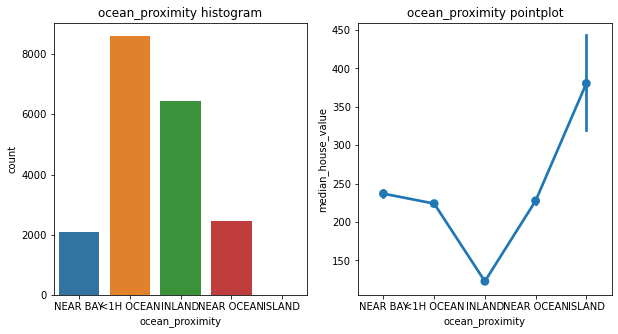

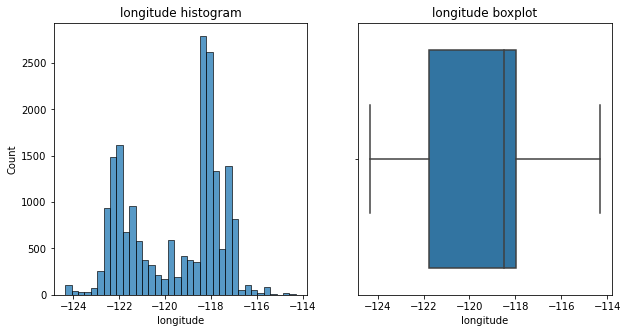

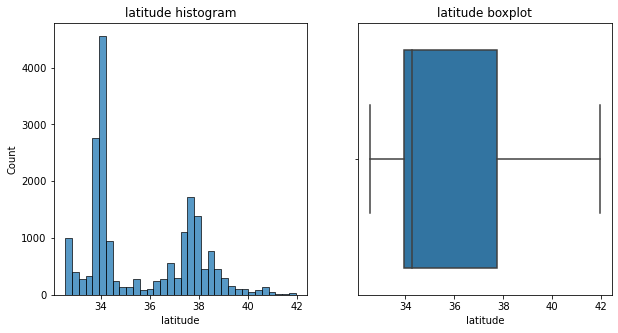

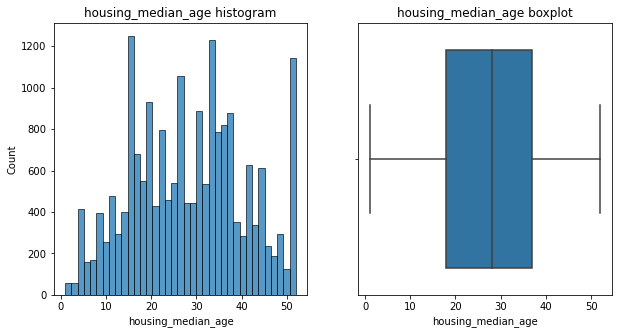

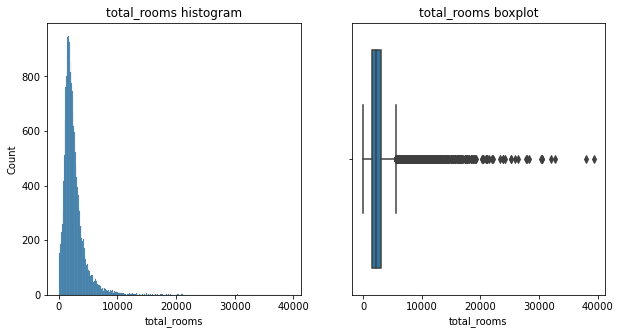

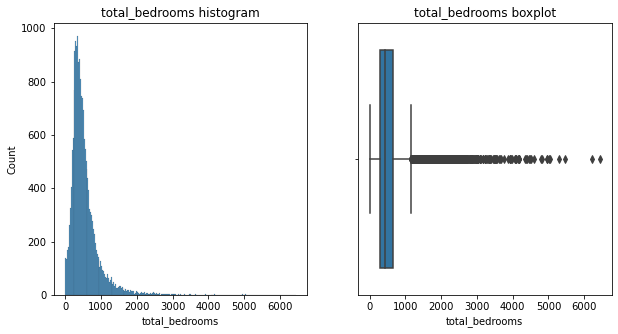

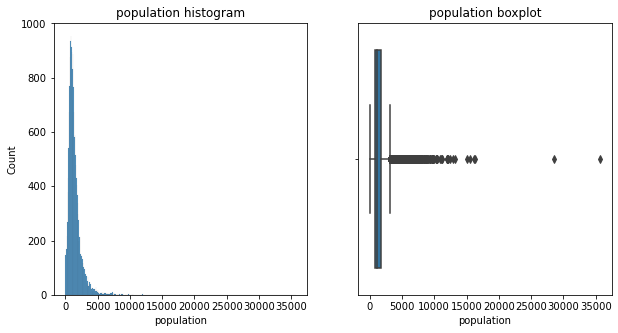

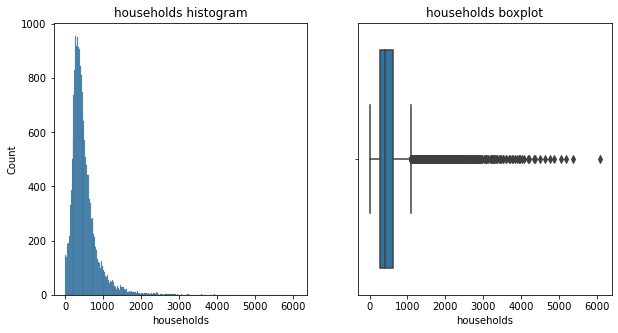

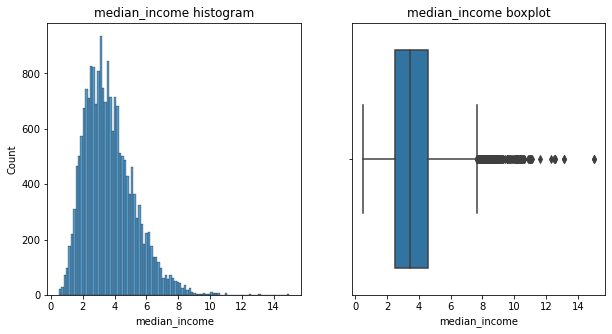

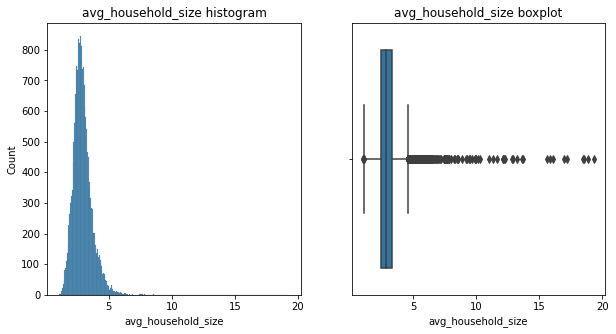

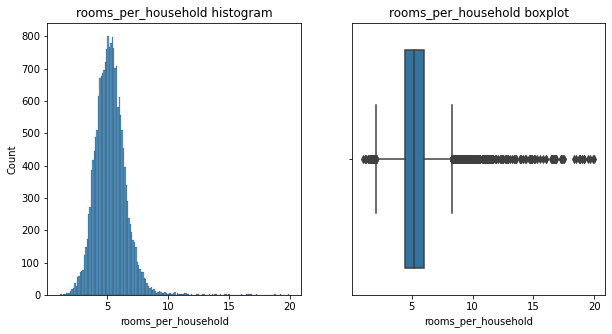

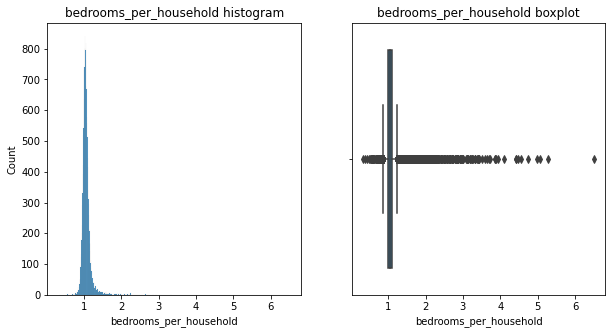

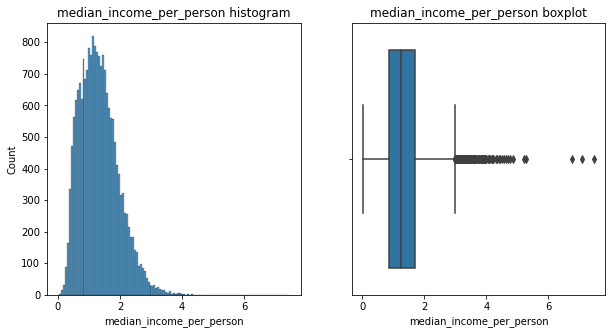

In [40]:
cat_feat_plot(df, cat, 'median_house_value')   
num_feat_plot(df, num, 'median_house_value')

In [41]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'avg_household_size',
       'rooms_per_household', 'bedrooms_per_household',
       'median_income_per_person'],
      dtype='object')

<Figure size 1080x720 with 0 Axes>

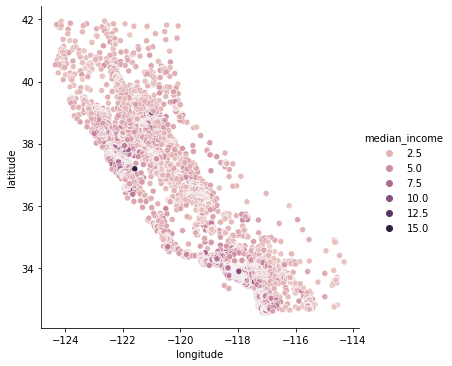

<Figure size 1080x720 with 0 Axes>

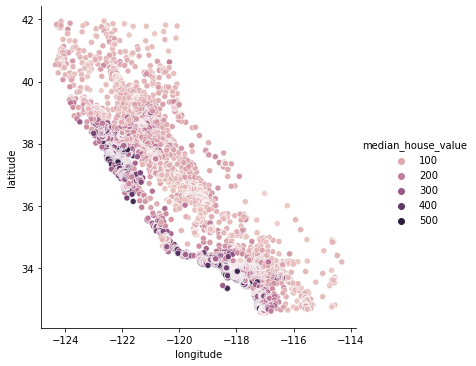

In [42]:
magic_scatterplot(df, 
                  ['median_income', 'median_house_value'],
                  "longitude",
                  'latitude')

Чем ближе океан, тем вышу средний доход и цена жилья

<Figure size 1080x720 with 0 Axes>

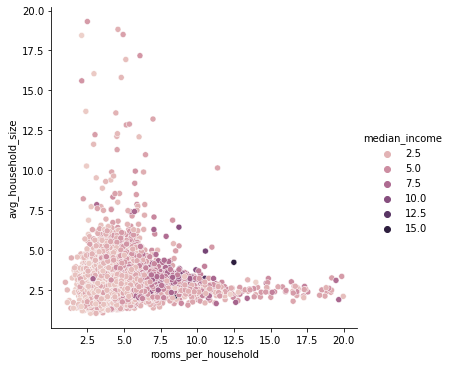

<Figure size 1080x720 with 0 Axes>

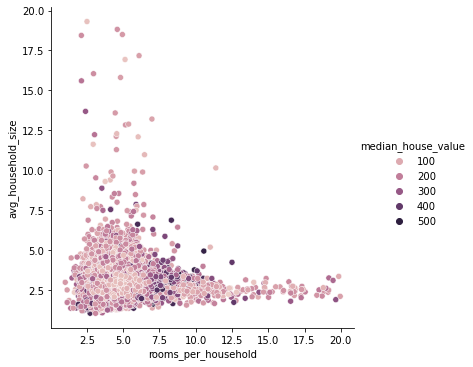

In [43]:
magic_scatterplot(df, 
                  ['median_income', 'median_house_value'],
                  "rooms_per_household",
                  'avg_household_size')

In [44]:
df[(df['rooms_per_household'] > 10) & (df['avg_household_size'] > 10)]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17891    -121.93      37.4                34.0        148.0            28.0   

       population  households  median_income  median_house_value  \
17891       132.0        13.0          3.375                67.5   

      ocean_proximity  avg_household_size  rooms_per_household  \
17891       <1H OCEAN           10.153846            11.384615   

       bedrooms_per_household  median_income_per_person  
17891                2.153846                  0.332386

Нашелся еще выброс

In [45]:
df = df.drop(df[(df['rooms_per_household'] > 10) & (df['avg_household_size'] > 10)].index)
df.shape[0] - rows_initial == -3 - 9 - 2 - 67 - 965 - 1

True

In [46]:
df.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              200
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
avg_household_size            0
rooms_per_household           0
bedrooms_per_household      200
median_income_per_person      0
dtype: int64

Хочу попробовать долготу и ширину в 1 фичу через РСА сделать

In [47]:
pca_proc = PCA(n_components=1)
df['coordinates_PCA'] = pca_proc.fit_transform(df[[ 'longitude', 'latitude']])
df['coordinates_PCA'][:10]
num.append('coordinates_PCA')

И посчитать как расстояние от точки, скажем,  минимальные долгота и ширина

In [48]:
min_lat = df['latitude'].min()
min_long = df['longitude'].min()

df['distance'] = haversine_np(df['longitude'], df['latitude'], min_long, min_lat)

num.append('distance')

Посмотрим на распределения, поделим на те переменные, которые буду обрабатывать MinMaxScaler и StandardScaler

In [49]:
df[num].describe()

longitude      latitude  housing_median_age   total_rooms  \
count  19593.000000  19593.000000        19593.000000  19593.000000   
mean    -119.563428     35.644499           28.419946   2618.915888   
std        2.007670      2.147014           12.501708   2178.695953   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.770000     33.930000           18.000000   1440.000000   
50%     -118.500000     34.270000           28.000000   2112.000000   
75%     -117.990000     37.720000           37.000000   3119.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count     19393.00000  19593.000000  19593.000000   19593.000000   
mean        539.63590   1443.623692    502.825193       3.676553   
std         422.04296   1140.291008    383.159396       1.567562   
min           2.00000      5.000000      2.000000       0.499900   
25%         298.00000    800.000000    283.000000       2.527200   
50%         437.00000   1182.000000    412.000000       3.450500   
75%         647.00000   1749.000000    607.000000       4.582800   
max        6445.00000  35682.000000   6082.000000      15.000100   

       avg_household_size  rooms_per_household  bedrooms_per_household  \
count        19593.000000         19593.000000            19393.000000   
mean             2.954145             5.268818                1.077969   
std              0.860982             1.372773                0.201142   
min              1.060606             1.000000                0.333333   
25%              2.447191             4.412281                1.005797   
50%              2.839009             5.179907                1.048437   
75%              3.306418             5.960967                1.098592   
max             19.312500            19.962121                6.500000   

       median_income_per_person  coordinates_PCA      distance  
count              19593.000000     1.959300e+04  19593.000000  
mean                   1.325042     6.962905e-15    633.574001  
std                    0.627017     2.884733e+00     78.042894  
min                    0.029060    -5.497245e+00    422.645783  
25%                    0.848951    -2.316965e+00    587.815386  
50%                    1.256978    -1.717086e+00    615.304495  
75%                    1.705429     3.111237e+00    668.415928  
max                    7.462508     7.762416e+00   1094.854216

In [50]:
df[num].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19593 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 19593 non-null  float64
 1   latitude                  19593 non-null  float64
 2   housing_median_age        19593 non-null  float64
 3   total_rooms               19593 non-null  float64
 4   total_bedrooms            19393 non-null  float64
 5   population                19593 non-null  float64
 6   households                19593 non-null  float64
 7   median_income             19593 non-null  float64
 8   avg_household_size        19593 non-null  float64
 9   rooms_per_household       19593 non-null  float64
 10  bedrooms_per_household    19393 non-null  float64
 11  median_income_per_person  19593 non-null  float64
 12  coordinates_PCA           19593 non-null  float64
 13  distance                  19593 non-null  float64
dtypes: flo

In [51]:
corr_price = df[num + target].corr(method='pearson') *100
# corr_price = corr_price[(corr_price['median_house_value'] > 20) | (corr_price['median_house_value'] < -20)]
f_num = list(corr_price.index)
f_num.remove('median_house_value')

<AxesSubplot:>

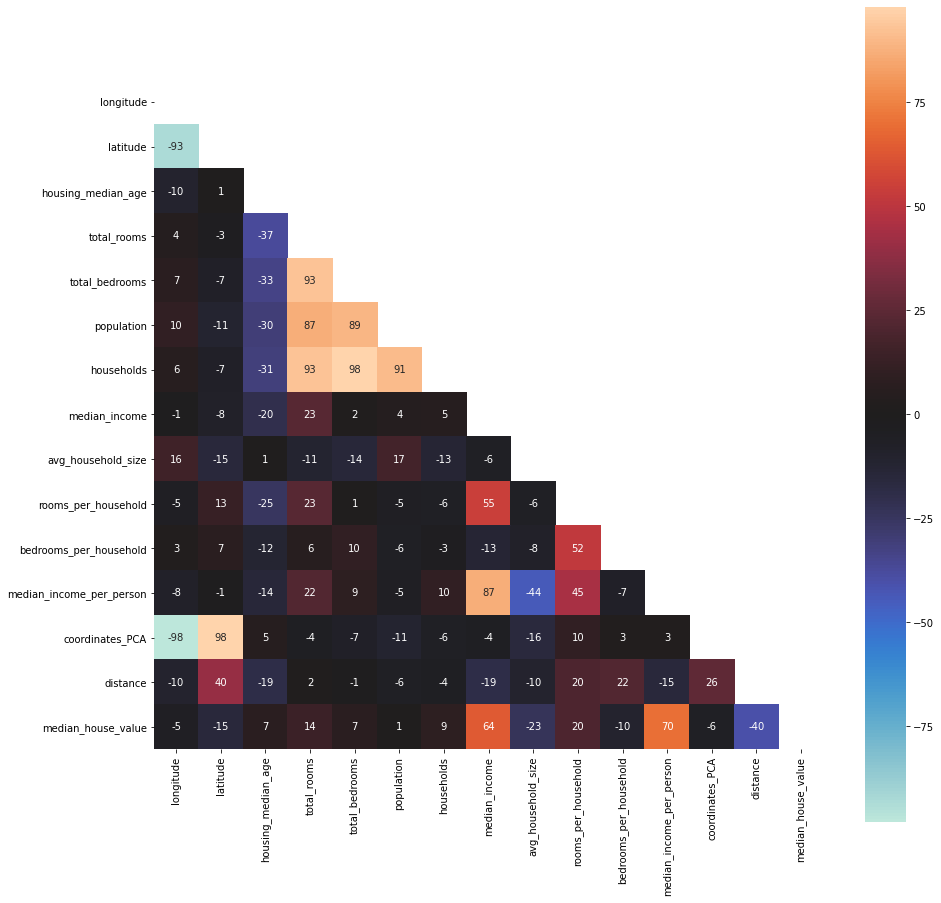

In [52]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df[f_num + target].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(np.round(corr * 100, 0), center=0, annot=True, square=True, ax=ax, mask=mask)

Поделим переменные на числовые для MinMaxScaler и для StandardScaler

In [53]:
num

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'avg_household_size',
 'rooms_per_household',
 'bedrooms_per_household',
 'median_income_per_person',
 'coordinates_PCA',
 'distance']

In [54]:
f_num_mm = [
    'housing_median_age',
    'distance'
]

f_num_ss = []
for el in f_num:
    if el not in f_num_mm:
        f_num_ss.append(el)

Переведем категориальные переменные в бинарные

In [55]:
ohe = OneHotEncoder()
ohe_matrix = ohe.fit_transform(df[cat])
ohe_matrix = ohe_matrix.toarray()

# формируем список наименований столбцов
ohe_cat_raw = dict(zip(cat, ohe.categories_))
f_2bin = [] # бинарные переменные

for key, value in ohe_cat_raw.items():
    for label in value:
        f_2bin.append(key + '_' + str(label))
                    
df_ohe_matrix = pd.DataFrame(ohe_matrix, columns=f_2bin)
df_ohe_matrix.index = df.index

df_ohe_matrix.head(3)

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     0.0   
2                        0.0                     0.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       1.0                         0.0  
1                       1.0                         0.0  
2                       1.0                         0.0

In [56]:
import sklearn
sklearn.__version__

'0.24.1'

In [57]:
f_bin = list(df_ohe_matrix.columns)
df = df.join(df_ohe_matrix)

In [58]:
corr_price = df[f_bin + target].corr(method='pearson') *100
f_bin = list(corr_price.index)
f_bin.remove('median_house_value')

<AxesSubplot:>

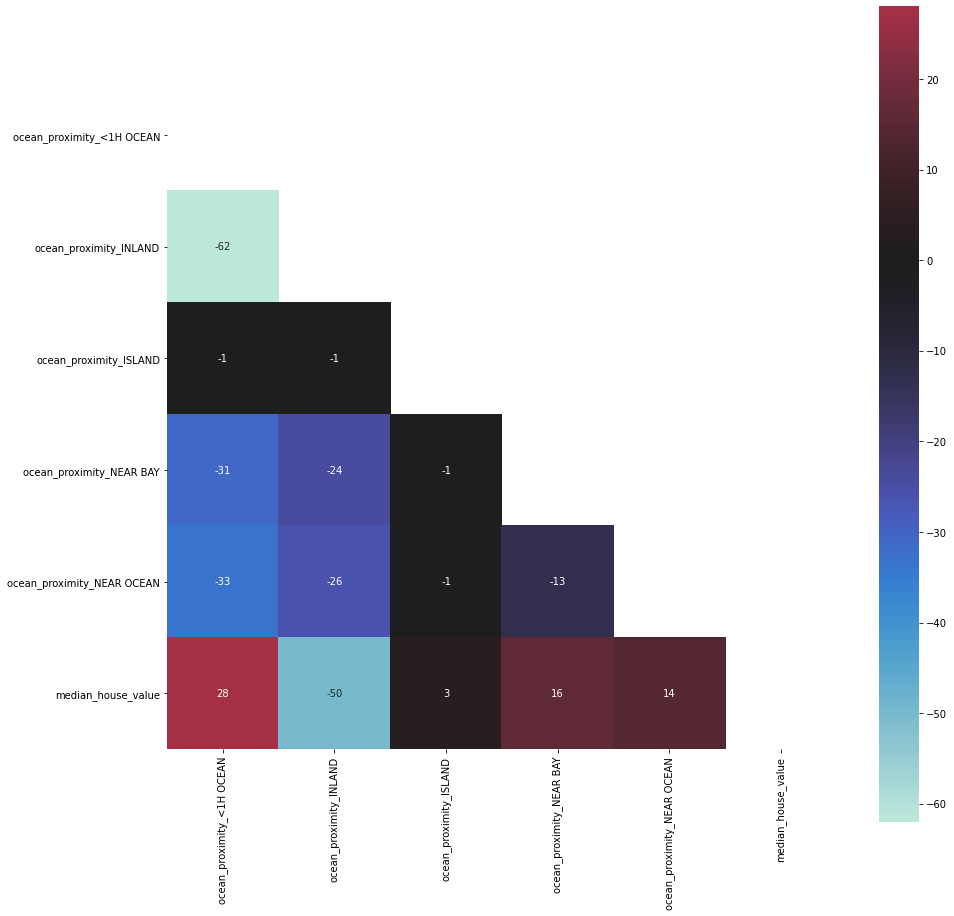

In [59]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df[f_bin + target].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(np.round(corr * 100, 0), center=0, annot=True, square=True, ax=ax, mask=mask)

### Моделирование

Используем линейную регрессию с L2 регуляризацией для построения модели по 'median_house_value'. Используем стандартизацию переменных.

In [60]:
train_df = df[f_bin + f_num_mm + f_num_ss + ['median_house_value']].copy()
X = train_df.drop(['median_house_value'], axis=1).copy()
y = train_df['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

# обработка пропусков\
median_bedrooms = X_train['bedrooms_per_household'].median()
X_train['bedrooms_per_household'] = X_train['bedrooms_per_household'].fillna(median_bedrooms)
X_train['total_bedrooms'] = X_train['total_bedrooms'].fillna(X_train['households'] * X_train['bedrooms_per_household'])

X_test['bedrooms_per_household'] = X_test['bedrooms_per_household'].fillna(median_bedrooms)
X_test['total_bedrooms'] = X_test['total_bedrooms'].fillna(X_test['households'] * X_test['bedrooms_per_household'])

standardscaler = StandardScaler()
standardscaler.fit(X_train[f_num_ss])
X_train[f_num_ss] = standardscaler.transform(X_train[f_num_ss])
X_test[f_num_ss] = standardscaler.transform(X_test[f_num_ss])

minmax = MinMaxScaler()
minmax.fit(X_train[f_num_mm])
X_train[f_num_mm] = minmax.transform(X_train[f_num_mm])
X_test[f_num_mm] = minmax.transform(X_test[f_num_mm])

In [61]:
# GridSearch
params = {"alpha": np.arange(0.25, 1.10, 0.25),
         "max_iter": [1000, 2000]}

# LogisticRegression()
results = GridSearchCV(Ridge(), params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
results.fit(X_train, y_train)
results.best_params_

{'alpha': 0.5, 'max_iter': 1000}

In [62]:
# обучаем модель и предсказываем
estimator = Ridge(max_iter=1000, alpha= 0.5)
estimator.fit(X_train, y_train)
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)

# оцениваем качество модели
print('Train')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'RMSE: {mean_squared_error(y_train, y_train_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_train, y_train_pred) ** 0.5 / y_train.median() *100, 1)}')
print('Test')
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_test_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_test, y_test_pred) ** 0.5 / y_test.median() *100, 1)}')

result_train = X_train.copy()
result_train['act'] = y_train
result_train['pred'] = y_train_pred

result_test = X_test.copy()
result_test['act'] = y_test
result_test['pred'] = y_test_pred

Train
MAE: 42.2013929528699
MSE: 3374.076987693658
RMSE: 58.086805624803105
RMSE as % of median: 33.4
Test
MAE: 42.67422550243103
MSE: 3360.0389072680396
RMSE: 57.96584259085724
RMSE as % of median: 33.3


In [63]:
(result_test['pred'].median() / result_test['act'].median()  - 1) *100

9.289571448601542

<AxesSubplot:>

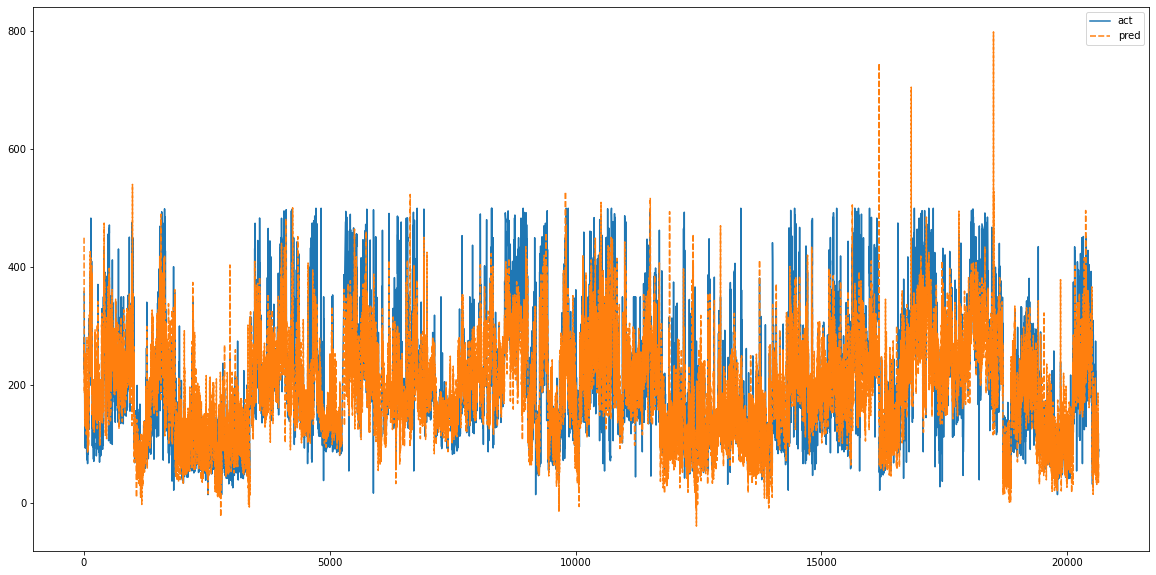

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=result_train[['act', 'pred']], linewidth=1.5)

<AxesSubplot:>

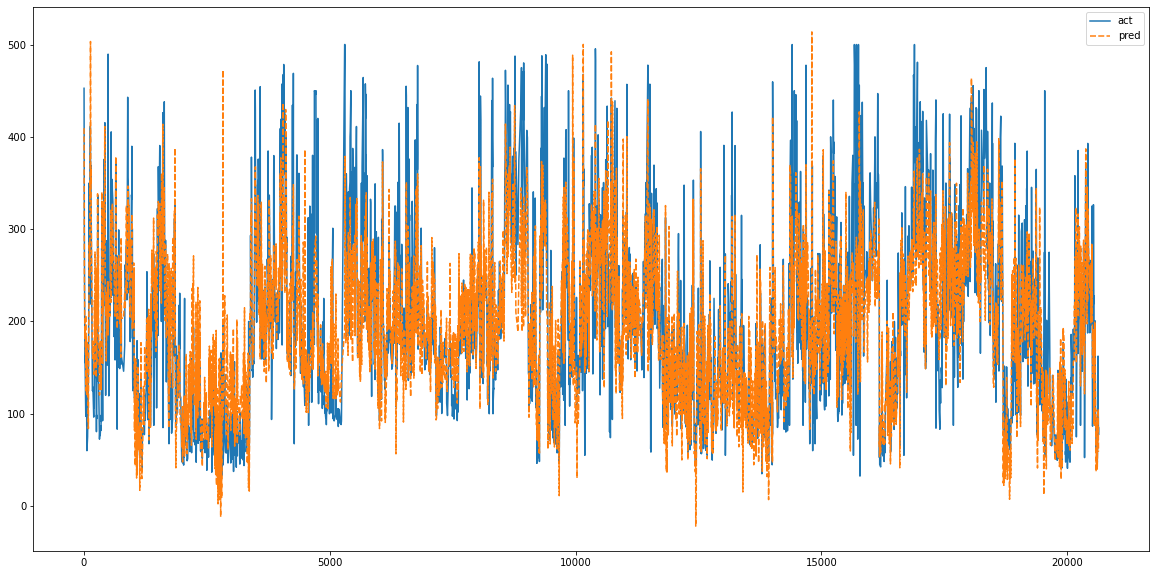

In [65]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=result_test[['act', 'pred']], linewidth=1.5)

<AxesSubplot:xlabel='act', ylabel='pred'>

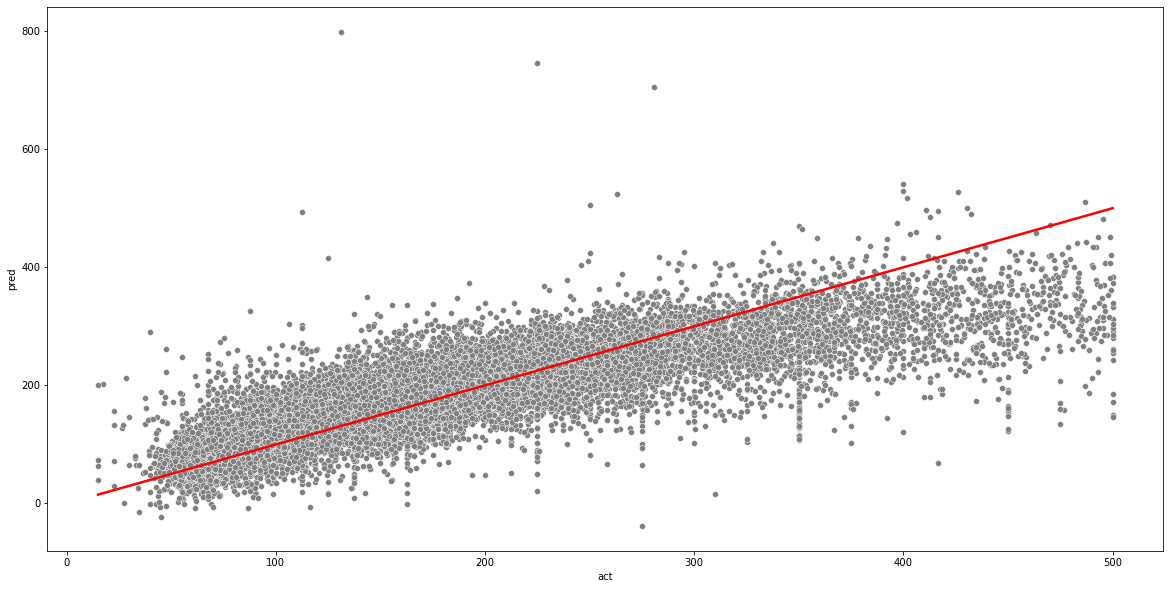

In [66]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=result_train[['act', 'pred']], x='act', y='pred', color='grey')
sns.lineplot(data=result_train[['act', 'pred']], x='act', y='act', linewidth=2.5, color='r')

<AxesSubplot:xlabel='act', ylabel='pred'>

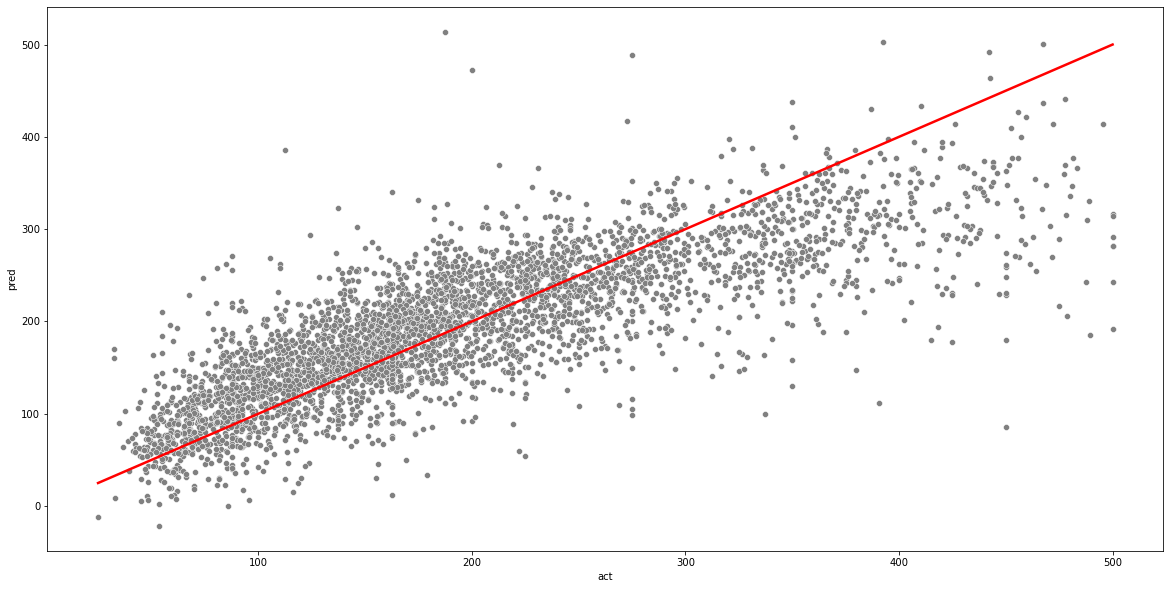

In [67]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=result_test[['act', 'pred']], x='act', y='pred', color='grey')
sns.lineplot(data=result_test[['act', 'pred']], x='act', y='act', linewidth=2.5, color='r')

In [68]:
q_l, q_h = iqr(df=df, column='median_house_value')
print('Нижняя граница {} и верхняя граница {}'.format(q_l, q_h))

Нижняя граница -81.00000000000001 и верхняя граница 314.40000000000003


In [69]:
len(df[df['median_house_value'] > 314]) / df.shape[0]

0.1307609860664523

> Модель визуально хорошо работает до стоимости жилья, равной 314 тыс. Попробую разбить на 2

In [70]:
df_01 = df.copy()
df_01 = df_01[df_01['median_house_value'] <= 314] # w/o outliers

In [71]:
df_02 = df.copy()
df_02 = df_02[df_02['median_house_value'] > 314] # outliers

In [72]:
train_df = df_01[f_bin + f_num_mm + f_num_ss + ['median_house_value']].copy()
X = train_df.drop(['median_house_value'], axis=1).copy()
y = train_df['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

# обработка пропусков\
median_bedrooms = X_train['bedrooms_per_household'].median()
X_train['bedrooms_per_household'] = X_train['bedrooms_per_household'].fillna(median_bedrooms)
X_train['total_bedrooms'] = X_train['total_bedrooms'].fillna(X_train['households'] * X_train['bedrooms_per_household'])

X_test['bedrooms_per_household'] = X_test['bedrooms_per_household'].fillna(median_bedrooms)
X_test['total_bedrooms'] = X_test['total_bedrooms'].fillna(X_test['households'] * X_test['bedrooms_per_household'])

standardscaler = StandardScaler()
standardscaler.fit(X_train[f_num_ss])
X_train[f_num_ss] = standardscaler.transform(X_train[f_num_ss])
X_test[f_num_ss] = standardscaler.transform(X_test[f_num_ss])

minmax = MinMaxScaler()
minmax.fit(X_train[f_num_mm])
X_train[f_num_mm] = minmax.transform(X_train[f_num_mm])
X_test[f_num_mm] = minmax.transform(X_test[f_num_mm])

In [73]:
# GridSearch
params = {"alpha": np.arange(0.25, 1.10, 0.25),
         "max_iter": [1000, 2000]}

# LogisticRegression()
results = GridSearchCV(Ridge(), params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
results.fit(X_train, y_train)
results.best_params_

{'alpha': 0.25, 'max_iter': 1000}

In [74]:
# обучаем модель и предсказываем
estimator = Ridge(max_iter=1000, alpha= 0.25)
estimator.fit(X_train, y_train)
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)

# оцениваем качество модели
print('Train')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'RMSE: {mean_squared_error(y_train, y_train_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_train, y_train_pred) ** 0.5 / y_train.median() *100, 1)}')
print('Test')
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_test_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_test, y_test_pred) ** 0.5 / y_test.median() *100, 1)}')

result_train = X_train.copy()
result_train['act'] = y_train
result_train['pred'] = y_train_pred

result_test = X_test.copy()
result_test['act'] = y_test
result_test['pred'] = y_test_pred

Train
MAE: 31.62016293145527
MSE: 1700.6389429911706
RMSE: 41.23880385015029
RMSE as % of median: 25.8
Test
MAE: 32.10816222478989
MSE: 1779.725344691766
RMSE: 42.18679111631703
RMSE as % of median: 26.1


In [75]:
(result_test['pred'].median() / result_test['act'].median()  - 1) *100

2.0805677435673964

<AxesSubplot:>

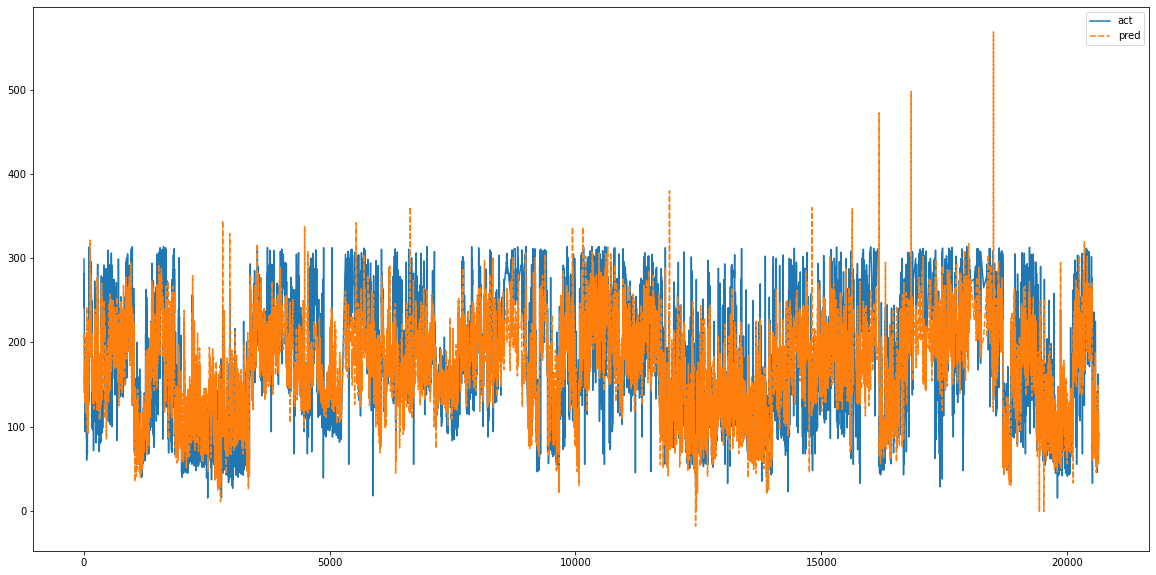

In [76]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=result_train[['act', 'pred']], linewidth=1.5)

<AxesSubplot:>

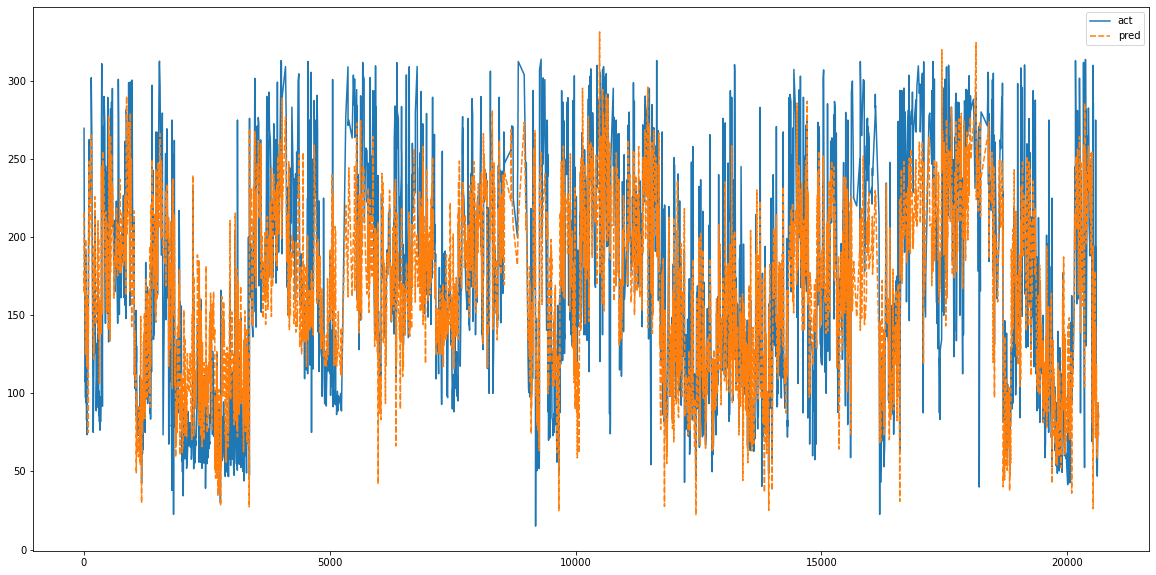

In [77]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=result_test[['act', 'pred']], linewidth=1.5)

<AxesSubplot:xlabel='act', ylabel='pred'>

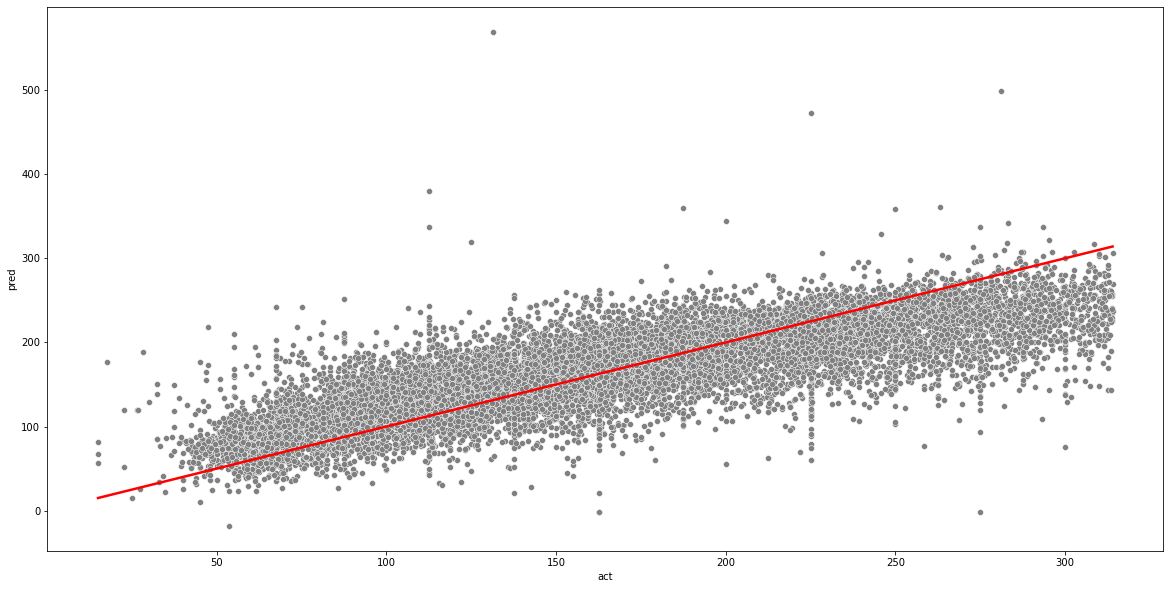

In [78]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=result_train[['act', 'pred']], x='act', y='pred', color='grey')
sns.lineplot(data=result_train[['act', 'pred']], x='act', y='act', linewidth=2.5, color='r')

<AxesSubplot:xlabel='act', ylabel='pred'>

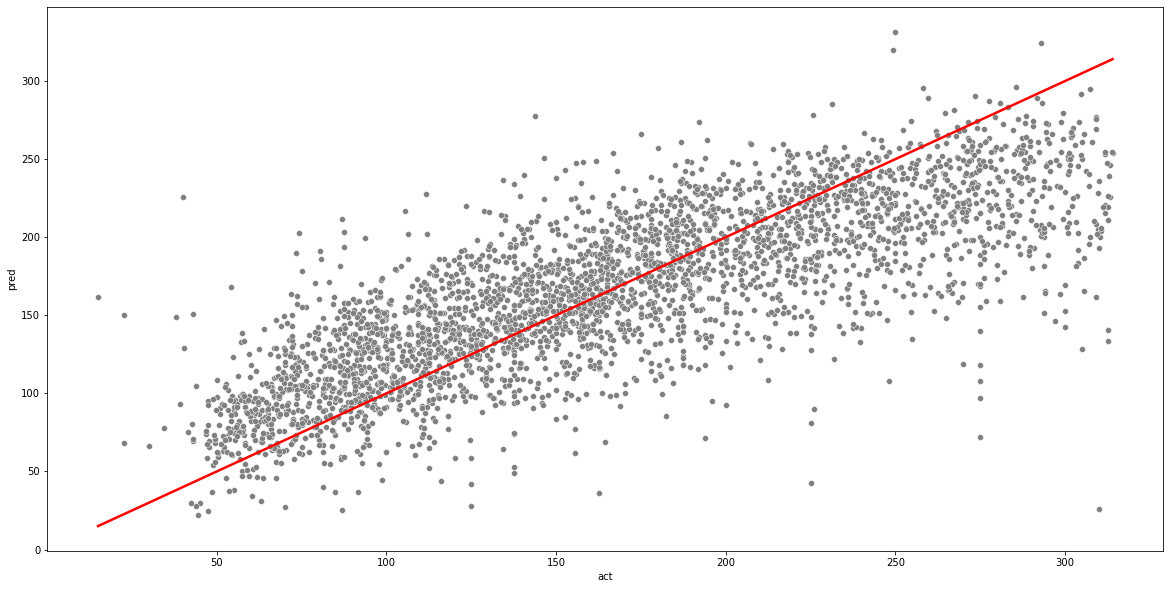

In [79]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=result_test[['act', 'pred']], x='act', y='pred', color='grey')
sns.lineplot(data=result_test[['act', 'pred']], x='act', y='act', linewidth=2.5, color='r')

In [80]:
train_df = df_02[f_bin + f_num_mm + f_num_ss + ['median_house_value']].copy()
X = train_df.drop(['median_house_value'], axis=1).copy()
y = train_df['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

# обработка пропусков\
median_bedrooms = X_train['bedrooms_per_household'].median()
X_train['bedrooms_per_household'] = X_train['bedrooms_per_household'].fillna(median_bedrooms)
X_train['total_bedrooms'] = X_train['total_bedrooms'].fillna(X_train['households'] * X_train['bedrooms_per_household'])

X_test['bedrooms_per_household'] = X_test['bedrooms_per_household'].fillna(median_bedrooms)
X_test['total_bedrooms'] = X_test['total_bedrooms'].fillna(X_test['households'] * X_test['bedrooms_per_household'])

standardscaler = StandardScaler()
standardscaler.fit(X_train[f_num_ss])
X_train[f_num_ss] = standardscaler.transform(X_train[f_num_ss])
X_test[f_num_ss] = standardscaler.transform(X_test[f_num_ss])

minmax = MinMaxScaler()
minmax.fit(X_train[f_num_mm])
X_train[f_num_mm] = minmax.transform(X_train[f_num_mm])
X_test[f_num_mm] = minmax.transform(X_test[f_num_mm])

In [81]:
# GridSearch
params = {"alpha": np.arange(0.25, 1.10, 0.25),
         "max_iter": [1000, 2000]}

# LogisticRegression()
results = GridSearchCV(Ridge(), params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
results.fit(X_train, y_train)
results.best_params_

{'alpha': 0.25, 'max_iter': 1000}

In [82]:
# обучаем модель и предсказываем
estimator = Ridge(max_iter=1000, alpha= 0.25)
estimator.fit(X_train, y_train)
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)

# оцениваем качество модели
print('Train')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'RMSE: {mean_squared_error(y_train, y_train_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_train, y_train_pred) ** 0.5 / y_train.median() *100, 1)}')
print('Test')
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_test_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_test, y_test_pred) ** 0.5 / y_test.median() *100, 1)}')

result_train = X_train.copy()
result_train['act'] = y_train
result_train['pred'] = y_train_pred

result_test = X_test.copy()
result_test['act'] = y_test
result_test['pred'] = y_test_pred

Train
MAE: 37.95363334869376
MSE: 2125.7818865928466
RMSE: 46.106202257319424
RMSE as % of median: 12.6
Test
MAE: 39.58842497620377
MSE: 2380.5322666085367
RMSE: 48.79069856651508
RMSE as % of median: 13.3


In [83]:
(result_test['pred'].median() / result_test['act'].median()  - 1) *100

3.1357035303197778

<AxesSubplot:>

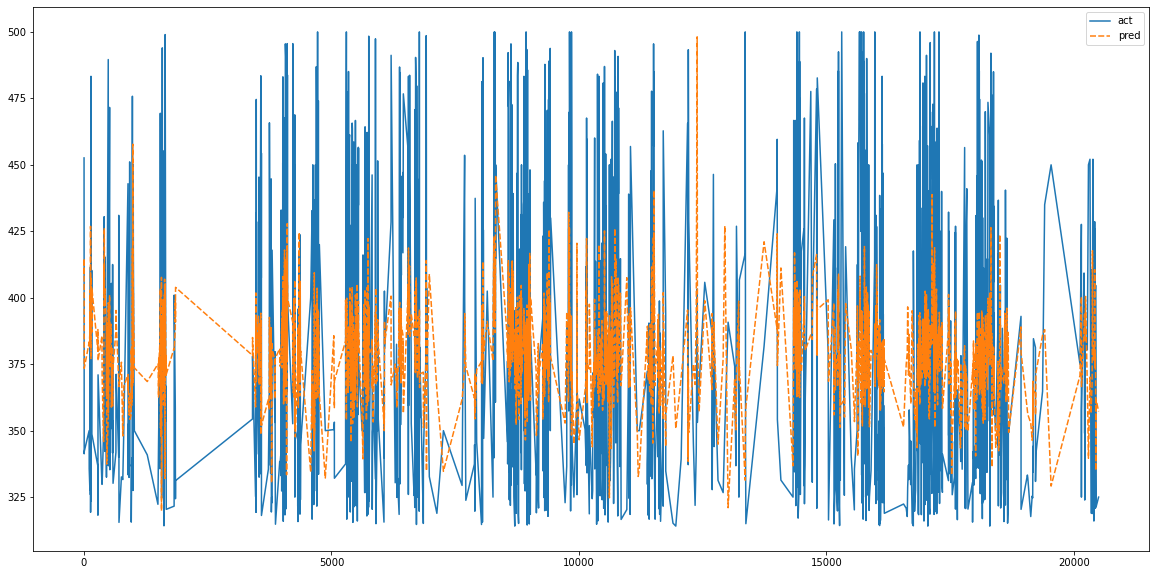

In [84]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=result_train[['act', 'pred']], linewidth=1.5)

<AxesSubplot:>

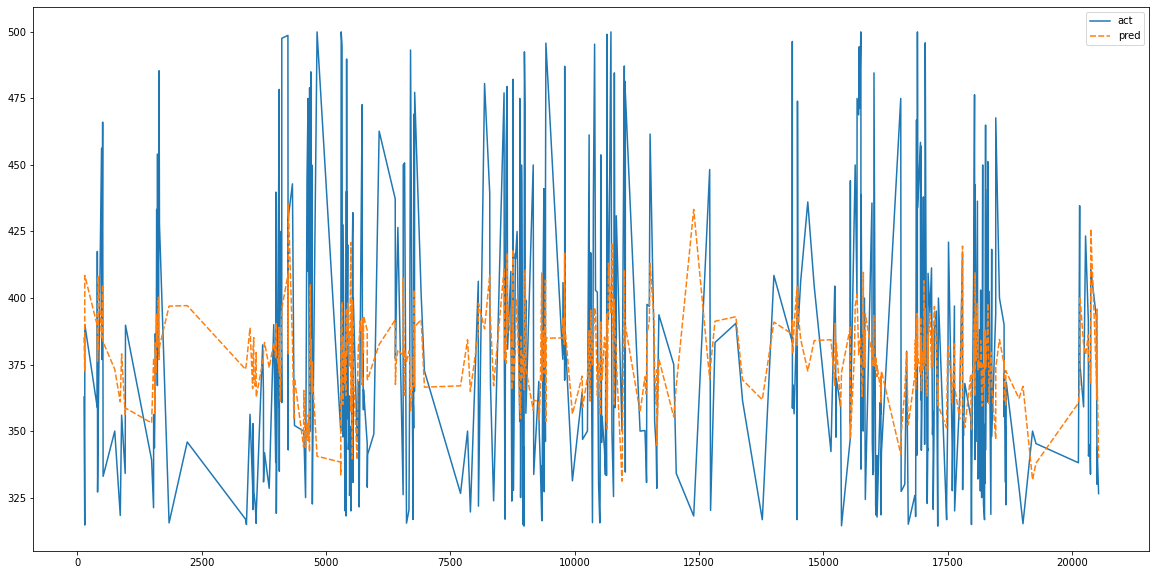

In [85]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=result_test[['act', 'pred']], linewidth=1.5)

<AxesSubplot:xlabel='act', ylabel='pred'>

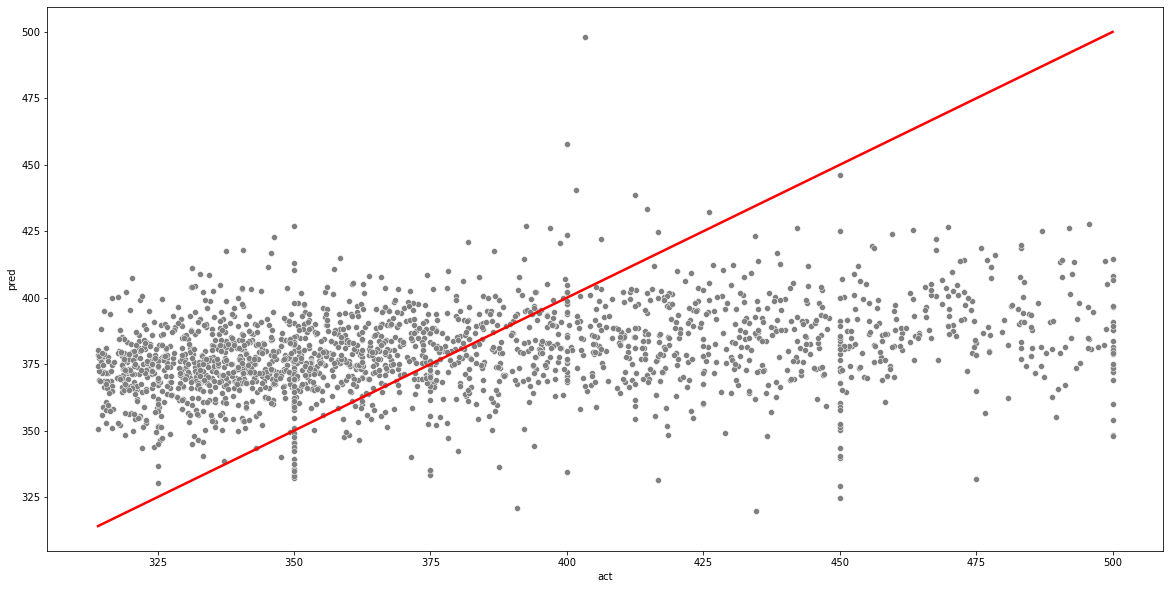

In [86]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=result_train[['act', 'pred']], x='act', y='pred', color='grey')
sns.lineplot(data=result_train[['act', 'pred']], x='act', y='act', linewidth=2.5, color='r')

<AxesSubplot:xlabel='act', ylabel='pred'>

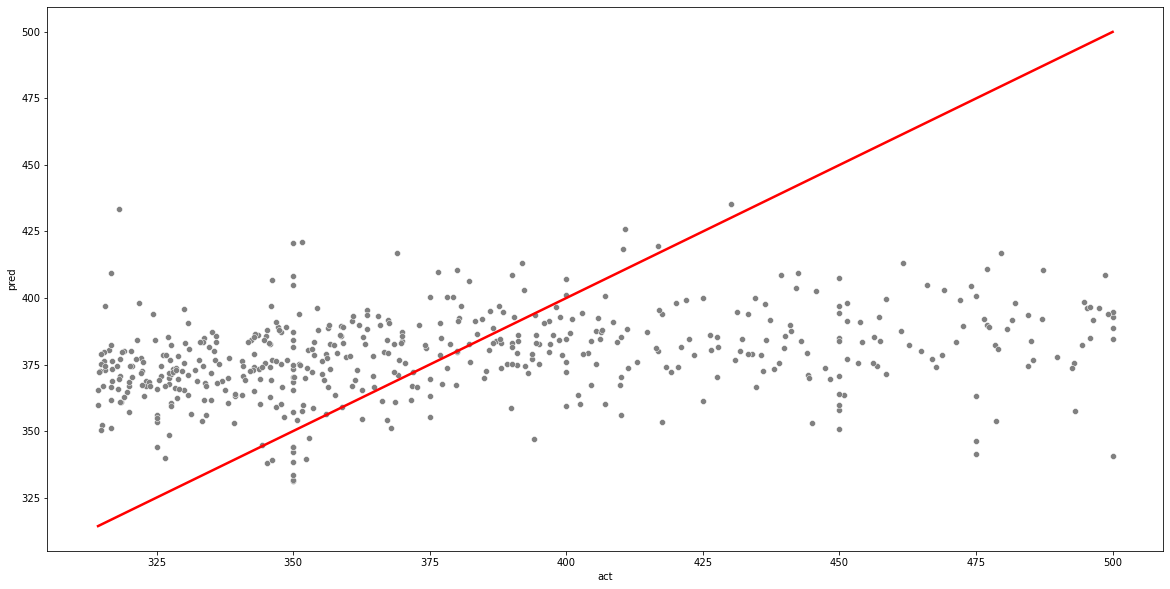

In [87]:
fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=result_test[['act', 'pred']], x='act', y='pred', color='grey')
sns.lineplot(data=result_test[['act', 'pred']], x='act', y='act', linewidth=2.5, color='r')

<AxesSubplot:>

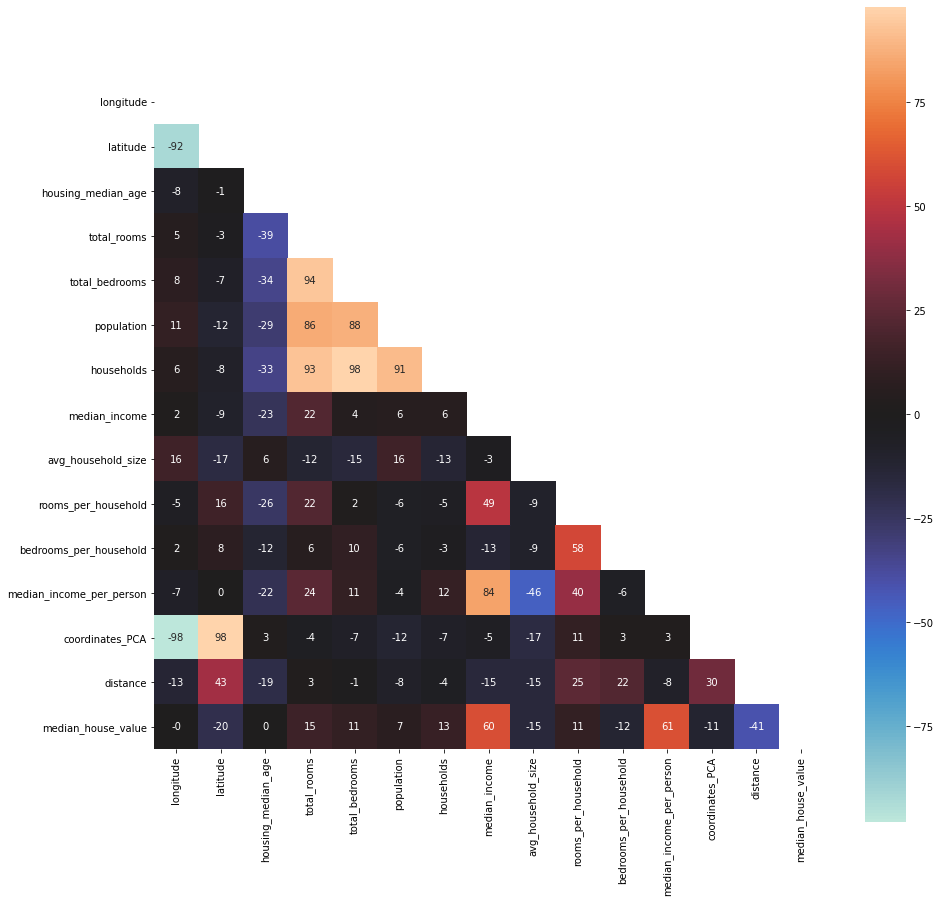

In [88]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df_01[f_num + target].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(np.round(corr * 100, 0), center=0, annot=True, square=True, ax=ax, mask=mask)

<AxesSubplot:>

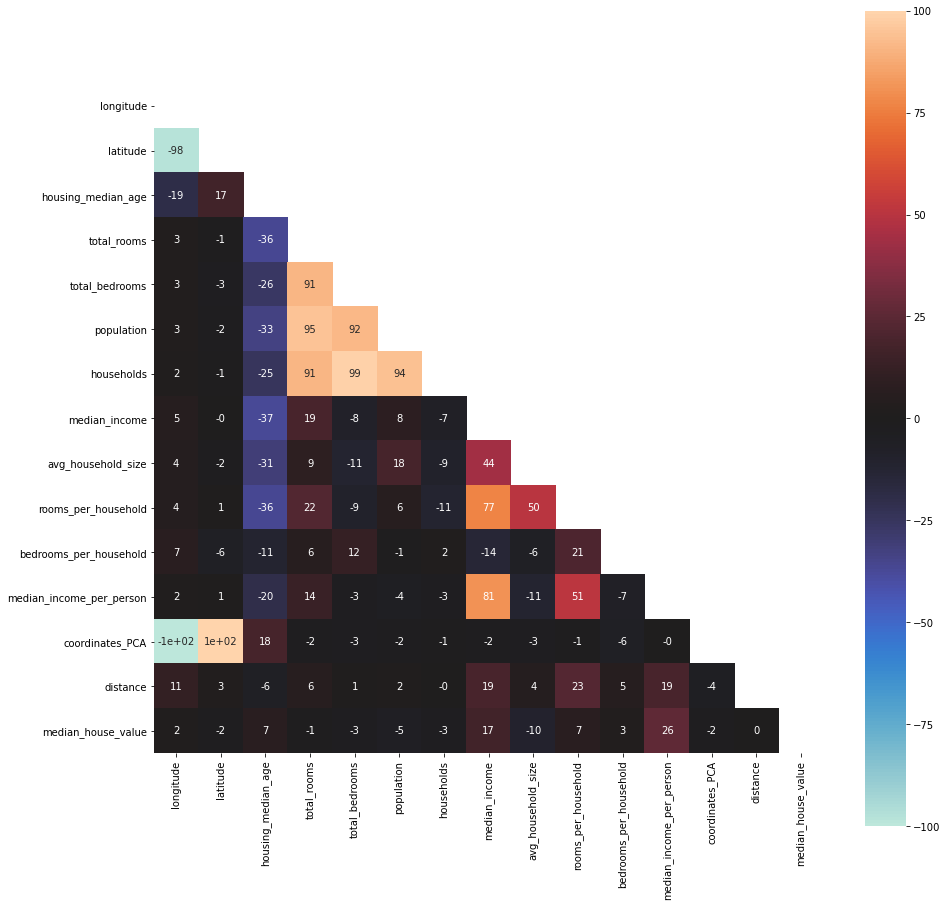

In [89]:
fig, ax = plt.subplots(figsize=(15,15))
corr = df_02[f_num + target].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(np.round(corr * 100, 0), center=0, annot=True, square=True, ax=ax, mask=mask)

> Вот тут, честно говоря, хочется убрать из датасета все строки, где стоимость жилья выше 314 тысяч. Это outlier по расчету 1.5 IQR, да и по корреляции нет ничего интересного. Не применима модель к данным наблюдениям - результат очень странный.

Используем линейную регрессию с L2 регуляризацией + PCA для построения модели по 'median_house_value', df_01. Используем стандартизацию переменных.

In [95]:
train_df = df_01[f_bin + f_num_mm + f_num_ss + ['median_house_value']].copy()
X = train_df.drop(['median_house_value'], axis=1).copy()
y = train_df['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

# обработка пропусков
median_bedrooms = X_train['bedrooms_per_household'].median()
X_train['bedrooms_per_household'] = X_train['bedrooms_per_household'].fillna(median_bedrooms)
X_train['total_bedrooms'] = X_train['total_bedrooms'].fillna(X_train['households'] * X_train['bedrooms_per_household'])

X_test['bedrooms_per_household'] = X_test['bedrooms_per_household'].fillna(median_bedrooms)
X_test['total_bedrooms'] = X_test['total_bedrooms'].fillna(X_test['households'] * X_test['bedrooms_per_household'])

standardscaler = StandardScaler()
standardscaler.fit(X_train[f_num_ss])
X_train[f_num_ss] = standardscaler.transform(X_train[f_num_ss])
X_test[f_num_ss] = standardscaler.transform(X_test[f_num_ss])

minmax = MinMaxScaler()
minmax.fit(X_train[f_num_mm])
X_train[f_num_mm] = minmax.transform(X_train[f_num_mm])
X_test[f_num_mm] = minmax.transform(X_test[f_num_mm])

In [96]:
pca_proc = PCA(n_components=10, random_state=42)
X_train_pca = pca_proc.fit_transform(X_train)
X_test_pca = pca_proc.transform(X_test)

In [97]:
# GridSearch
params = {"alpha": np.arange(0.25, 1.10, 0.25),
         "max_iter": [1000, 2000]}

# LogisticRegression()
results = GridSearchCV(Ridge(), params, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
results.fit(X_train_pca, y_train)
results.best_params_

{'alpha': 1.0, 'max_iter': 1000}

In [98]:
# обучаем модель и предсказываем
estimator = Ridge(max_iter=1000, alpha= 1)
estimator.fit(X_train_pca, y_train)
y_train_pred = estimator.predict(X_train_pca)
y_test_pred = estimator.predict(X_test_pca)

# оцениваем качество модели
print('Train')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'RMSE: {mean_squared_error(y_train, y_train_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_train, y_train_pred) ** 0.5 / y_train.median() *100, 1)}')
print('Test')
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_test_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_test, y_test_pred) ** 0.5 / y_test.median() *100, 1)}')

result_train = X_train.copy()
result_train['act'] = y_train
result_train['pred'] = y_train_pred

result_test = X_test.copy()
result_test['act'] = y_test
result_test['pred'] = y_test_pred

Train
MAE: 31.959803410539145
MSE: 1761.391711772307
RMSE: 41.9689374629893
RMSE as % of median: 26.2
Test
MAE: 32.519931196529015
MSE: 1839.0842660368407
RMSE: 42.88454577160449
RMSE as % of median: 26.6


In [99]:
(result_test['pred'].median() / result_test['act'].median()  - 1) *100

2.335574102701976

Используем KNeighborsRegressor для построения модели по 'median_house_value', df_01. Используем стандартизацию переменных.

In [100]:
train_df = df_01[f_bin + f_num_mm + f_num_ss + ['median_house_value']].copy()
X = train_df.drop(['median_house_value'], axis=1).copy()
y = train_df['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.copy()
X_test = X_test.copy()

# обработка пропусков
median_bedrooms = X_train['bedrooms_per_household'].median()
X_train['bedrooms_per_household'] = X_train['bedrooms_per_household'].fillna(median_bedrooms)
X_train['total_bedrooms'] = X_train['total_bedrooms'].fillna(X_train['households'] * X_train['bedrooms_per_household'])

X_test['bedrooms_per_household'] = X_test['bedrooms_per_household'].fillna(median_bedrooms)
X_test['total_bedrooms'] = X_test['total_bedrooms'].fillna(X_test['households'] * X_test['bedrooms_per_household'])

standardscaler = StandardScaler()
standardscaler.fit(X_train[f_num_ss])
X_train[f_num_ss] = standardscaler.transform(X_train[f_num_ss])
X_test[f_num_ss] = standardscaler.transform(X_test[f_num_ss])

minmax = MinMaxScaler()
minmax.fit(X_train[f_num_mm])
X_train[f_num_mm] = minmax.transform(X_train[f_num_mm])
X_test[f_num_mm] = minmax.transform(X_test[f_num_mm])

In [101]:
neib = KNeighborsRegressor(n_neighbors=11, weights='distance', metric='cosine', n_jobs=-1)
neib.fit(X_train, y_train)
y_train_pred = neib.predict(X_train)
y_test_pred = neib.predict(X_test)

# оцениваем качество модели
print('Train')
print(f'MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MSE: {mean_squared_error(y_train, y_train_pred)}')
print(f'RMSE: {mean_squared_error(y_train, y_train_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_train, y_train_pred) ** 0.5 / y_train.median() *100, 1)}')
print('Test')
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_test_pred) ** 0.5}')
print(f'RMSE as % of median: {round(mean_squared_error(y_test, y_test_pred) ** 0.5 / y_test.median() *100, 1)}')

result_train = X_train.copy()
result_train['act'] = y_train
result_train['pred'] = y_train_pred

result_test = X_test.copy()
result_test['act'] = y_test
result_test['pred'] = y_test_pred

Train
MAE: 9.233016256683664e-13
MSE: 6.445655178045956e-24
RMSE: 2.5388294897542757e-12
RMSE as % of median: 0.0
Test
MAE: 27.643978189530316
MSE: 1432.3818699440608
RMSE: 37.846821133934895
RMSE as % of median: 23.4


In [102]:
(result_test['pred'].median() / result_test['act'].median()  - 1) *100

1.6681452057355717

> Модель линейной регрессии с L2 регуляризацией показала лучший результат, где убрала аутлаер по целевой переменной. </br>
> Train  </br>
> RMSE: 41.23880385015029  </br>
> RMSE as % of median: 25.8  </br>
> Test  </br>
> RMSE: 42.18679111631703  </br>
> RMSE as % of median: 26.1  </br>

> kNN переобучился (на трейне RMSE практически 0, на тесте - 37,8), хотя на тесте результат еще лучше.